# <span style="color:yellow">New Classes and Some Functions</span>

In [1]:
from TMclass import *
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xml.etree import ElementTree
from datetime import datetime as DT
from datetime import timedelta as TD

TM3 = {'date':[], 'tm_rate':[], 'duration':[]}
TM3n = {'date':[], 'tm_rate':[], 'duration':[]}

# you have to remove what is inside <eventfile>
with open('../SIFECS_NMP_Segment_2_withLTP10-11FECS.xml') as f:
	tree = ElementTree.parse(f)

for node in tree.iter('PASS'):
    d = DT.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S").date()
    if d >= datetime.date(2023,1,1) and d <= datetime.date(2024,1,1):
        TM3['date'] += [DT.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S")]
        TM3['tm_rate'] += [float(node.attrib.get('tm_rate'))]
        TM3['duration'] += [int(node.attrib.get('duration'))]

TM3['date'] = np.asarray(TM3['date'])
TM3['tm_rate'] = np.asarray(TM3['tm_rate'])
TM3['duration'] = np.asarray(TM3['duration'])

with open('../FECS_2023072_2023177_2022348130413_v03.SOL') as f:
	tree = ElementTree.parse(f)
for node in tree.iter('PASS'):
    d = DT.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S").date()
    if d >= datetime.date(2023,1,1) and d <= datetime.date(2024,1,1):
        TM3n['date'] += [DT.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S")]
        TM3n['tm_rate'] += [float(node.attrib.get('tm_rate'))]
        TM3n['duration'] += [int(node.attrib.get('duration'))]

TM3n['date'] = np.asarray(TM3n['date'])
TM3n['tm_rate'] = np.asarray(TM3n['tm_rate'])
TM3n['duration'] = np.asarray(TM3n['duration'])

idx0 = np.where(TM3['date'] > TM3n['date'][0])[0][0]
idx1 = np.where(TM3['date'] < TM3n['date'][-1])[0][-1]
TM3['date'] = np.concatenate((TM3['date'][:idx0],TM3n['date'],TM3['date'][idx1:]))
TM3['tm_rate'] = np.concatenate((TM3['tm_rate'][:idx0],TM3n['tm_rate'],TM3['tm_rate'][idx1:]))
TM3['duration'] = np.concatenate((TM3['duration'][:idx0],TM3n['duration'],TM3['duration'][idx1:]))

f = open('../phi.itl','r')
lines = f.readlines()

FL = {'date':[], 'flush':[]}

for x in lines:
    temp = x.split(' ')
    if 'PHI_SCI_Flush_VOL' in temp[-1]:
        FL['date'] += [DT.fromisoformat(temp[0][:-1])]
        FL['flush'] += [float(temp[-1][19:-2])]
        # print(temp[0][:-1],temp[-1][19:-2])

FL['date'] = np.asarray(FL['date'])
FL['flush'] = np.asarray(FL['flush'])

# for i in range(np.size(TM3['date'])):
#     j = 0
#     if TM3['date'][i] >= TM3n['date'][0] and TM3['date'][i] <= TM3n['date'][-1]:
#         TM3['date'][i] = TM3n['date'][j]
#         TM3['tm_rate'][i] = TM3n['tm_rate'][j]
#         TM3['duration'][i] = TM3n['duration'][j]
#         j += 1

In [2]:
def flush_many(PHI,max_vol, vol_dataset, phi_mode, start, nbits, ndata, level, partition):
    # global PHI
    # global phi
    
    def _new_start(start,end):
        start += TD(days=1)
        start = start.replace(hour=22,minute=0,second=0)
        if end > start:
            start = end + TD(hours=1)
        return start
    
    vol0 = max_vol[0]
    vol1 = max_vol[1]
    n0 = int(vol0 // vol_dataset * 0.99)
    n1 = int(vol1 // vol_dataset * 0.99)

    if ndata == -1:
        ndata = phi_mode.level_out(level).n_datasets
    
    print(f'Days needed: {(ndata-n0)//n1+2}')
    kw = phi_mode.compressing(start, nbits = nbits, ndata = n0,level=level); PHI.saving(partition,**kw)
    # start += TD(days=1)
    start = _new_start(start,kw['end'])

    for i in range((ndata-n0)//n1+1):
        kw = phi_mode.compressing(start, nbits = nbits, ndata = min(ndata - n0 - i*n1,n1),level=level); PHI.saving(partition,**kw)
        start = _new_start(start,kw['end'])

    return (phi_mode, kw)
    
def synoptic(PHI,mode,t0,t1,cadence,shape,nout,nbits,i,format = False):
    # t0 = DT.fromisoformat('2023-04-15T00:00:00')
    # t1 = DT.fromisoformat('2023-05-01T00:00:00')

    # cad = 6*60
    # global PHI
    N = int((t1 - t0).total_seconds() / (60*cadence))

    ti = t0
#     deltat = (t1 - t0)/N
    deltat = TD(minutes=cadence)
    
    min2 = TD(minutes=2)
    form = False
    for n in range(N):
        kw = mode.observation(ti,ti+min2,cadence=2,shape=shape); PHI.saving(i,**kw)
        if shape[1] != 2048:
            kw = mode.cropping(kw['end'] + TD(minutes=5),ndata=-1,crop=[shape[1],shape[1]],level='raw'); PHI.saving(i,**kw)
            kw = mode.processing(kw['end'] + TD(minutes=5),ndata=-1,partialStore=0x00,level='raw.crop',nout=nout); PHI.saving(i,**kw)
            kw = mode.compressing(kw['end'] + TD(minutes=5), nbits = nbits, ndata = -1,level='raw.crop.proc'); PHI.saving(i,**kw)
        else:
            kw = mode.processing(kw['end'] + TD(minutes=5),ndata=-1,partialStore=0x00,level='raw',nout=nout); PHI.saving(i,**kw)
            kw = mode.compressing(kw['end'] + TD(minutes=5), nbits = nbits, ndata = -1,level='raw.proc'); PHI.saving(i,**kw)
        ti = ti + deltat
        if format:
            if PHI.part1.occu > 220e3 or PHI.part2.occu > 220e3:
                PHI.format_partition(i,kw['end'])
                i = i%2 + 1

def synoptic_raw(PHI,mode,t0,t1,cadence,shape,nbits,i, crop_pack = False, format = False):
    # t0 = DT.fromisoformat('2023-04-15T00:00:00')
    # t1 = DT.fromisoformat('2023-05-01T00:00:00')

    # cad = 6*60
    # global PHI
    N = int((t1 - t0).total_seconds() / (60*cadence))

    ti = t0
#     deltat = (t1 - t0)/N
    deltat = TD(minutes=cadence)
    
    min2 = TD(minutes=2)
    form = False
    for n in range(N):
        kw = mode.observation(ti,ti+min2,cadence=2,shape=shape); PHI.saving(i,**kw)
        if shape[1] != 2048:
            kw = mode.cropping(kw['end'] + TD(minutes=5),ndata=-1,crop=[shape[1],shape[1]],level='raw');
            if crop_pack == False:
                PHI.saving(i,**kw)
            kw = mode.packing(kw['end'] + TD(minutes=5),ndata=-1,level='raw.crop'); PHI.saving(i,**kw)
            kw = mode.compressing(kw['end'] + TD(minutes=5), nbits = nbits, ndata = -1,level='raw.crop.pack'); PHI.saving(i,**kw)
        else:
            kw = mode.packing(kw['end'] + TD(minutes=5),ndata=-1,level='raw'); PHI.saving(i,**kw)
            kw = mode.compressing(kw['end'] + TD(minutes=5), nbits = nbits, ndata = -1,level='raw.pack'); PHI.saving(i,**kw)
        ti = ti + deltat
        if format:
            if PHI.part1.occu > 220e3 or PHI.part2.occu > 220e3:
                PHI.format_partition(i,kw['end'])
                i = i%2 + 1

def FDT_flat(PHI,t0,idx,proc='auto',flush='auto',verbose=True):

    # global PHI
    t1 = t0+TD(minutes=55)
    proc_time = TD(hours=5)

    FDTf1 = PHI_MODE('FDT')

    kw = FDTf1.observation(t0,t1,cadence=6,shape=(2048,2048,4,6)); PHI.saving(idx,**kw)
    if proc == 'auto':
        t0 = kw['end']+TD(minutes=5)
    else:
        t0 = proc
    kw = FDTf1.observation(t0,1,cadence=proc_time.total_seconds()/60,shape=(2048,2048,4,6)); PHI.saving(idx,**kw)
    kw = FDTf1.packing(t0,ndata=1,level='raw',); PHI.saving(idx,**kw)

    if flush == 'auto':
        t0 = kw['end'] + TD(hours=1)
    else:
        t0 = flush
    kw = FDTf1.compressing(t0,ndata=1,nbits=6,level='raw.pack'); PHI.saving(idx,**kw)

    ########################################################
    if verbose:
        printp(FDTf1, label='FDT Flat Calibration')
        plot_tot(PHI,ylim=(0,250),time_ord=True)

    return FDTf1

def HRT_flat(PHI,t0,idx,proc='auto',flush='auto',verbose=True):
    # global PHI
    proc_time = TD(minutes=15)

    HRTf1 = PHI_MODE('FDT')

    kw = HRTf1.observation(t0,10,cadence=40,shape=(2048,2048,4,6)); PHI.saving(idx,**kw)
    
    if proc == 'auto':
        t0 = kw['end']+TD(minutes=5)
    else:
        t0 = proc
    kw = HRTf1.observation(t0,1,cadence=proc_time.total_seconds()/60,shape=(2048,2048,4,6)); PHI.saving(idx,**kw)
    kw = HRTf1.packing(kw['end'],ndata=1,level='raw',); PHI.saving(idx,**kw)

    if flush == 'auto':
        t0 = kw['end'] + TD(hours=1)
    else:
        t0 = flush
    kw = HRTf1.compressing(t0,ndata=1,nbits=6,level='raw.pack'); PHI.saving(idx,**kw)

    ########################################################
    if verbose:
        printp(HRTf1, label='HRT Flat Calibration')
        plot_tot(PHI,ylim=(0,250),time_ord=True)

    return HRTf1

def HRT_kll(PHI,t0,idx,proc='auto',flush='auto',verbose=True):
    # global PHI
    t1 = t0+TD(minutes=55)
    proc_time = TD(hours=5)

    HRTf1 = PHI_MODE('FDT')

    kw = HRTf1.observation(t0,t1,cadence=6,shape=(2048,2048,4,6)); PHI.saving(idx,**kw)
    if proc == 'auto':
        t0 = kw['end']+TD(minutes=5)
    else:
        t0 = proc
    kw = HRTf1.observation(t0,1,cadence=proc_time.total_seconds()/60,shape=(2048,2048,4,6)); PHI.saving(idx,**kw)
    kw = HRTf1.packing(t0,ndata=1,level='raw',); PHI.saving(idx,**kw)

    if flush == 'auto':
        t0 = kw['end'] + TD(hours=1)
    else:
        t0 = flush
    kw = HRTf1.compressing(t0,ndata=1,nbits=6,level='raw.pack'); PHI.saving(idx,**kw)

    ########################################################
    if verbose:
        printp(HRTf1, label='HRT Kll Calibration')
        plot_tot(PHI,ylim=(0,250),time_ord=True)

    return HRTf1

def plot_flush_per_day(PHI,xlim=None, values=False):
    temp = PHI.part1.history    # plt.subplot(121)
    c1 = np.asarray(PHI.part1.history['compr'])
    c2 = np.asarray(PHI.part2.history['compr'])

    d1 = np.asarray(PHI.part1.history['start'])
    d2 = np.asarray(PHI.part2.history['start'])

    starttime = min(d1[0],d2[0])
    endtime = max(max(d1),max(d2))
    t0 = starttime
    times = []
    while starttime.date() <= endtime.date():
        times.append(starttime.date())
        starttime += datetime.timedelta(days=1)
    starttime = t0; del t0
    times_float = [(t - d1[0]).total_seconds() for t in d1]
    times = np.asarray(times)

    newc1 = np.zeros(np.size(times))
    for i,j in zip(d1,c1):
        if j>=0:
            ind = np.where(times == i.date())[0]
            newc1[ind] += j/1e3
    newc1 = np.asarray(newc1)

    newc2 = np.zeros(np.size(times))
    for i,j in zip(d2,c2):
        if j>=0:
            ind = np.where(times == i.date())[0]
            newc2[ind] += j/1e3
    newc2 = np.asarray(newc2)

    total = 0
    for i,t in enumerate(times):
        if t >= xlim[0].date() and t<= xlim[1].date():
            total += newc1[i] + newc2[i]

    plt.figure(figsize=(15,12))
    # plt.plot_date(times,newc1,color='blue',linestyle='-',marker='.',label='partition 1')
    # plt.plot_date(times,newc2,color='red',linestyle='-',marker='.',label='partition 2')
    plt.plot_date(times,newc1+newc2,color='black',linestyle='-',marker='.',label='total: '+str(round(total,1))+' GB')
    plt.gcf().autofmt_xdate()
    plt.grid()
    plt.legend()
    if xlim is not None:
        plt.xlim(xlim)
    plt.ylabel('flush (GB/day)')

    if values:
        return times, newc1, newc2


(0.0, 4500.0)

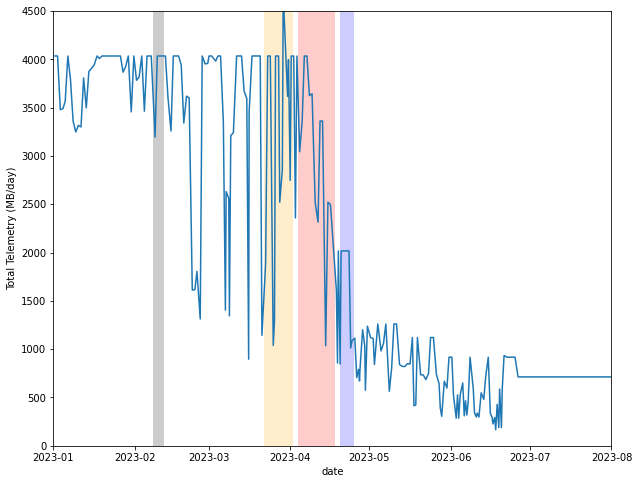

In [3]:
plt.figure(figsize=(10,8))
plt.plot(TM3['date'], (TM3['tm_rate']*TM3['duration'])/8/1e6)#; plt.ylim(0,5000)
plt.ylim(0,4500)
ylim = plt.gca().get_ylim()
plt.fill_betweenx(ylim,DT(2023,2,8),DT(2023,2,12),facecolor='black',alpha=.2)
plt.fill_betweenx(ylim,DT(2023,3,22),DT(2023,4,2),facecolor='orange',alpha=.2)
plt.fill_betweenx(ylim,DT(2023,4,4),DT(2023,4,18),facecolor='red',alpha=.2)
plt.fill_betweenx(ylim,DT(2023,4,20),DT(2023,4,25),facecolor='blue',alpha=.2)
plt.xlim(datetime.date(2023,1,1),datetime.date(2023,8,1))
plt.ylabel('Total Telemetry (MB/day)')
plt.xlabel('date')
plt.ylim(ylim)

# <span style="color:white">*out of RSWs*</span>

## <span style="color:blue">R_FULL_LRES_HCAD_Full-Disk-Helioseismology</span>

CROP+PACK


In [6]:
t0 = DT.fromisoformat('2023-02-08T00:00:00')
t1 = DT.fromisoformat('2023-02-10T12:00:00')
PHI = PHI_MEMORY(t0)
phi = PHI_MEMORY(t0)

hcrop = 768
hsm_1 = PHI_MODE('FDT')
kw = hsm_1.observation(t0,t1,cadence=1,shape=(2048,hcrop,1,6)); PHI.saving(1,**kw)

# t0 = hsm_1.raw.end

# PHI.copy_partition(1,t0)
# PHI.format_partition(1,PHI.part1.history['end'][-1])


t0 = DT.fromisoformat('2023-02-10T12:00:00')
t1 = DT.fromisoformat('2023-02-13T00:00:00')
hsm_2 = PHI_MODE('FDT')
kw = hsm_2.observation(t0,t1,cadence=1,shape=(2048,hcrop,1,6)); PHI.saving(2,**kw)

t0 = hsm_2.raw.end

kw = hsm_1.cropping(t0,ndata=-1,crop=[hcrop,hcrop],level='raw');# PHI.saving(1,**kw)
kw = hsm_1.packing(hsm_1.raw.crop.end,ndata=-1,level='raw.crop'); PHI.saving(1,**kw)

# kw = hsm_1.compressing(hsm_1.raw.pack.end, nbits = 6, ndata = -1,level='raw.pack'); PHI.saving(1,**kw)
hsm_1, kw = flush_many(PHI,[1350,1350], 2.4, hsm_1, kw['end'], 6, -1, 'raw.crop.pack',1)

t0 = hsm_1.raw.crop.pack.compr.end
kw = hsm_2.cropping(t0,ndata=-1,crop=[hcrop,hcrop],level='raw');# PHI.saving(2,**kw)
kw = hsm_2.packing(hsm_2.raw.crop.end,ndata=-1,level='raw.crop'); PHI.saving(2,**kw)

# kw = hsm_2.compressing(a1_2.raw.pack.end, nbits = 6, ndata = -1,level='raw.pack'); PHI.saving(2,**kw)
hsm_2, kw = flush_many(PHI,[1350,1350], 2.4, hsm_2, kw['end'], 6, -1, 'raw.crop.pack',2)

end = kw['end']
########################################################
printp(hsm_1, label='R_FULL_LRES_HCAD_Full-Disk-Helioseismology - Partition 1')
print('==========================\n')
printp(hsm_2, label='R_FULL_LRES_HCAD_Full-Disk-Helioseismology - Partition 2')
# plot_tot(PHI)

Days needed: 7
Days needed: 7
R_FULL_LRES_HCAD_Full-Disk-Helioseismology - Partition 1
number of datasets: 3600
cadence: 1 mins
duration: 2 days, 12:00:00
amount of raw-data at 32 bits: 164794.9 MiB, 45.8 MiB per dataset
crop size: 768
amount of crop-data at 32 bits: 82397.5 MiB, 22.9 MiB per dataset
cropping time: 1 day, 11:00:00
amount of pack-data at 16 bits: 54931.6 MiB, 15.3 MiB per dataset
packing time: 1 day, 21:00:00
amount of compressed data + metadata at 6 bits: 9519.6 MiB, 2.6 MiB per dataset
compressing (+ flushing) time: 22:10:56.278731
amount of metadata:  86426.4 MiB
amount of memory usage: 302124.0 MiB


R_FULL_LRES_HCAD_Full-Disk-Helioseismology - Partition 2
number of datasets: 3600
cadence: 1 mins
duration: 2 days, 12:00:00
amount of raw-data at 32 bits: 164794.9 MiB, 45.8 MiB per dataset
crop size: 768
amount of crop-data at 32 bits: 82397.5 MiB, 22.9 MiB per dataset
cropping time: 1 day, 11:00:00
amount of pack-data at 16 bits: 54931.6 MiB, 15.3 MiB per dataset
pac

In [6]:
hsm_1.raw.crop.pack.time.total_seconds()/60/60/24

1.5

In [7]:
print('cropping and packing duration:',(hsm_1.raw.crop.pack.time + hsm_1.raw.crop.time)*2)
print('compression duration:',(hsm_1.raw.crop.pack.compr.time)*2)

cropping and packing duration: 5 days, 8:00:00
compression duration: 1 day, 10:05:20.624640


## <span style="color:magenta">***RESET NANDs***</span>

In [5]:
print('amount of compressed data + metadata in partition 1:',round(PHI.part1.compr*1e-3,2), 'GB')
print('amount of compressed data + metadata in partition 2:',round(PHI.part2.compr*1e-3,2), 'GB')
# print('TM time:',round((PHI.part1.compr + PHI.part2.compr)/2151.3,2), 'days')
# PHI.format_partition(1,DT(2023,1,29,16,0,0))
# PHI.format_partition(2,end + TD(hours=1))
# PHI.format_partition(1,end + TD(hours=1))
# PHI.format_partition(2,PHI.part1.history['end'][-1] + TD(hours=.5))
PHI.format_partition(1,DT(2023,2,28,1,0,0))
PHI.format_partition(2,DT(2023,2,28,6,0,0))

amount of compressed data + metadata in partition 1: 7.67 GB
amount of compressed data + metadata in partition 2: 7.67 GB


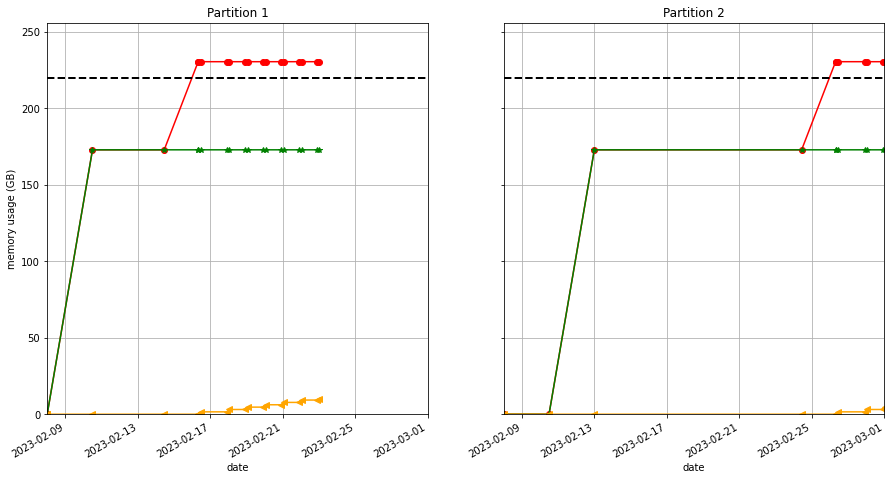

In [7]:
plot_tot(PHI,ylim=(0,256),xlim=(DT(2023,2,8),DT(2023,3,1)))

In [10]:
phi = PHI_MEMORY(DT.fromisoformat('2023-03-15T00:00:00'))

## <span style="color:blue">CC_OFFPOI_OOF </span>

PSP context

In [11]:
########################################################
id = 2

t0 = DT.fromisoformat('2023-03-15T11:45:00')
t1 = DT.fromisoformat('2023-03-15T14:45:00')
psp = PHI_MODE('HRT')
kw = psp.observation(t0,t1,cadence=60,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)

t0 = psp.raw.end+TD(minutes=20)
kw = psp.packing(t0,ndata=-1,level='raw'); phi.saving(id,**kw); PHI.saving(id,**kw); 
# kw = psp.compressing(psp.raw.pack.end+TD(minutes=10), nbits = 6, ndata = -1,level='raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw);
kw = psp.compressing(DT.fromisoformat('2023-03-15T22:00:00'), nbits = 6, ndata = -1,level='raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw);

########################################################
printp(psp, label='CC_OFFPOI_OOF - PSP context')


CC_OFFPOI_OOF - PSP context
number of datasets: 3
cadence: 60 mins
duration: 3:00:00
amount of raw-data at 32 bits: 1190.2 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 618.0 MiB, 206.0 MiB per dataset
packing time: 0:04:30
amount of compressed data + metadata at 6 bits: 216.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:30:12.155328
amount of metadata:  48.027 MiB
amount of memory usage: 1808.2 MiB



## <span style="color:blue">CC_OFFPOI_STRAYLIGHT </span>

In [12]:
########################################################
id = 2

t0 = DT.fromisoformat('2023-03-20T00:00:00')
t1 = DT.fromisoformat('2023-03-20T05:36:00')
stray = PHI_MODE('HRT')
kw = stray.observation(t0,3,cadence=90,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)

kw = stray.packing(DT(2023,3,20,15),ndata=-1,level='raw'); phi.saving(id,**kw); PHI.saving(id,**kw); 
# kw = stray.compressing(stray.raw.pack.end+TD(minutes=10), nbits = 6, ndata = -1,level='raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw);
kw = stray.compressing(DT.fromisoformat('2023-03-20T21:00:00'), nbits = 6, ndata = -1,level='raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw);
########################################################
printp(stray, label='CC_OFFPOI_STRAYLIGHT')


CC_OFFPOI_STRAYLIGHT
number of datasets: 3
cadence: 90 mins
duration: 4:30:00
amount of raw-data at 32 bits: 1190.2 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 618.0 MiB, 206.0 MiB per dataset
packing time: 0:04:30
amount of compressed data + metadata at 6 bits: 216.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:30:12.155328
amount of metadata:  48.027 MiB
amount of memory usage: 1808.2 MiB



## <span style="color:blue">CC_ROLLS_RS </span>

8 roll positions

In [13]:
########################################################
id = 2

t0 = DT.fromisoformat('2023-03-20T06:00:00')
t1 = DT.fromisoformat('2023-03-20T13:30:00')
roll = PHI_MODE('FDT')
kw = roll.observation(t0,8,cadence=60,shape=(2048,2048,1,5)); phi.saving(id,**kw); PHI.saving(id,**kw) # PD datasets

kw = roll.packing(DT(2023,3,20,15,15),ndata=-1,level='raw'); phi.saving(id,**kw); PHI.saving(id,**kw); 
# kw = roll.compressing(roll.raw.pack.end+TD(minutes=10), nbits = 6, ndata = -1,level='raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw);
kw = roll.compressing(DT.fromisoformat('2023-03-20T21:35:00'), nbits = 6, ndata = -1,level='raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw);

########################################################
printp(roll, label='CC_ROLLS_RS')


CC_ROLLS_RS
number of datasets: 8
cadence: 60 mins
duration: 8:00:00
amount of raw-data at 32 bits: 732.4 MiB, 91.6 MiB per dataset
amount of pack-data at 16 bits: 427.2 MiB, 53.4 MiB per dataset
packing time: 0:12:00
amount of compressed data + metadata at 6 bits: 120.1 MiB, 15.0 MiB per dataset
compressing (+ flushing) time: 0:16:47.208960
amount of metadata:  128.072 MiB
amount of memory usage: 1159.7 MiB



## <span style="color:green">HRT Flat 1</span>

In [83]:
########################################################
id = 2

t0 = DT.fromisoformat('2023-03-21T00:00:00')
t1 = DT.fromisoformat('2023-03-21T10:00:00')
HRTflat1 = HRT_flat(PHI,t0,id,DT(2023,3,21,11,0,0),flush=DT(2023,3,21,22,0,0),verbose=False)
########################################################
printp(HRTflat1, label="HRT FLAT 1 (21/03/2023)")

HRT FLAT 1 (21/03/2023)
number of datasets: 11
cadence: 15.0 mins
duration: 0:15:00
amount of raw-data at 32 bits: 4364.0 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 206.0 MiB, 206.0 MiB per dataset
packing time: 0:01:30
amount of compressed data + metadata at 6 bits: 72.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:10:04.051776
amount of metadata:  16.009 MiB
amount of memory usage: 4570.0 MiB



## <span style="color:green">FDT Flat 1 </span>

In [84]:
########################################################
id = 2

t0 = DT.fromisoformat('2023-03-21T20:00:00')
t1 = DT.fromisoformat('2023-03-21T21:00:00')
FDTflat1 = FDT_flat(PHI,t0,id,DT(2023,3,22,6,10),flush = DT(2023,3,22,12,30),verbose=False)
########################################################
printp(FDTflat1, label="FDT FLAT 1 (21/03/2023)")

FDT FLAT 1 (21/03/2023)
number of datasets: 10
cadence: 300.0 mins
duration: 5:00:00
amount of raw-data at 32 bits: 3967.3 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 206.0 MiB, 206.0 MiB per dataset
packing time: 0:01:30
amount of compressed data + metadata at 6 bits: 72.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:10:04.051776
amount of metadata:  16.009 MiB
amount of memory usage: 4173.3 MiB



# <span style="color:orange">*RSW 7*</span>

## <span style="color:blue">Crazy Mosaic</span>

In [85]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-03-22T00:00:00')
t1 = t0 + TD(minutes=175) #25 datasets
crazy = PHI_MODE('HRT')

kw = crazy.observation(t0,25,cadence=7,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = crazy.packing(DT(2023,3,22,5,0,0),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = crazy.compressing(DT(2023,3,22,22,0,0),ndata=-1,nbits=6,level='raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = crazy.compressing(DT(2023,3,22,18,35,0),ndata=-1,nbits=6,level='raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

########################################################
printp(crazy, label='Crazy Mosaic')


Crazy Mosaic
number of datasets: 25
cadence: 7 mins
duration: 2:55:00
amount of raw-data at 32 bits: 9918.2 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 5149.8 MiB, 206.0 MiB per dataset
packing time: 0:37:30
amount of compressed data + metadata at 6 bits: 1800.2 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 4:11:41.294400
amount of metadata:  400.225 MiB
amount of memory usage: 15068.1 MiB



## <span style="color:blue">Eruption Watch</span>

In [86]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-03-22T06:00:00')
t1 = DT.fromisoformat('2023-03-27T06:10:00')
ew1 = PHI_MODE('FDT')
crop = 1536

kw = ew1.observation(t0,t1,cadence=360,shape=(2048,crop,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
for i in range(5):
    kw = ew1.cropping(DT(2023,3,23,18,30,0)+TD(days=i),crop=crop,ndata=4,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
    kw = ew1.packing(kw['end']+TD(minutes=5),ndata=4,level = 'raw.crop'); phi.saving(id,**kw); PHI.saving(id,**kw)
    kw = ew1.compressing(DT(2023,3,23,20,15,0)+TD(days=i),ndata=4,nbits=6,level='raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

########################################################
t0 = DT.fromisoformat('2023-03-27T01:00:00')
# t1 = DT.fromisoformat('2023-03-27T05:10:00')
FDTcc = PHI_MODE('FDT')
crop = 1536

kw = FDTcc.observation(t0,30,cadence=100/60,shape=(2048,crop,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = FDTcc.cropping(kw['end']+TD(minutes=5),crop=crop,ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = FDTcc.packing(kw['end']+TD(minutes=5),ndata=-1,level = 'raw.crop'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = FDTcc.compressing(DT(2023,3,27,3,30,0),ndata=-1,nbits=6,level='raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)


########################################################
printp(ew1, label='Eruption Watch 1')
printp(FDTcc, label='FDT cross calibration')


Eruption Watch 1
number of datasets: 20
cadence: 360 mins
duration: 5 days, 0:10:00
amount of raw-data at 32 bits: 5950.9 MiB, 297.5 MiB per dataset
crop size: 1536
amount of crop-data at 32 bits: 4577.6 MiB, 228.9 MiB per dataset
cropping time: 0:23:20
amount of pack-data at 16 bits: 2441.4 MiB, 122.1 MiB per dataset
packing time: 0:30:00
amount of compressed data + metadata at 6 bits: 810.2 MiB, 40.5 MiB per dataset
compressing (+ flushing) time: 1:53:16.212480
amount of metadata:  224.036 MiB
amount of memory usage: 12970.0 MiB

FDT cross calibration
number of datasets: 30
cadence: 1.6666666666666667 mins
duration: 0:50:00
amount of raw-data at 32 bits: 8926.4 MiB, 297.5 MiB per dataset
crop size: 1536
amount of crop-data at 32 bits: 6866.5 MiB, 228.9 MiB per dataset
cropping time: 0:35:00
amount of pack-data at 16 bits: 3662.1 MiB, 122.1 MiB per dataset
packing time: 0:45:00
amount of compressed data + metadata at 6 bits: 1215.3 MiB, 40.5 MiB per dataset
compressing (+ flushing) ti

## <span style="color:blue">Composition Mosaic</span>

12 pointings, 4h each, used for HRTcc

<span style="color:red">cadence could be reduced to 90m to save telemetry</span>

24 datasets (6 pointings, 4 datasets each + 2 for hinode)

In [87]:
########################################################
id = 1
t0 = DT.fromisoformat('2023-03-27T06:00:00')
t1 = DT.fromisoformat('2023-03-29T06:18:51')
CM1 = PHI_MODE('HRT')

#cadence from 30 to 60 for putting 3h high cadence
kw = CM1.observation(t0,26,cadence=60,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = CM1.packing(DT(2023,4,2,10,0,0),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
# CM1, kw = flush_many(PHI,[1200,1200],72,CM1,DT(2023,4,3,22,0,0),6,-1,'raw.pack',id)
kw = CM1.compressing(DT(2023,4,3,19,0,0),ndata=12,nbits=6,level='raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = CM1.compressing(DT(2023,4,4,9,0,0),ndata=12,nbits=6,level='raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = CM1.compressing(DT(2023,4,5,19,5,0),ndata=2,nbits=6,level='raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = CM1.compressing(DT(2023,4,6,19,5,0),ndata=12,nbits=6,level='raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

########################################################
printp(CM1, label='Connection Mosaic')


Connection Mosaic
number of datasets: 26
cadence: 60 mins
duration: 1 day, 2:00:00
amount of raw-data at 32 bits: 10314.9 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 5355.8 MiB, 206.0 MiB per dataset
packing time: 0:39:00
amount of compressed data + metadata at 6 bits: 1872.2 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 4:21:45.346176
amount of metadata:  416.018 MiB
amount of memory usage: 15670.8 MiB



## <span style="color:blue">RS-burst 1</span>
4h@1m. SOOP is 4h30m, but it could be complicated for telemetry. CROP+PACK

<span style="color:red">duration could be reduced to 3h to save telemetry</span>

In [88]:
########################################################
id = 1
t0 = DT.fromisoformat('2023-03-29T11:10:00')
t1 = DT.fromisoformat('2023-03-29T20:10:00')
RShrt1 = PHI_MODE('HRT')
RSfdt1 = PHI_MODE('FDT')
# RSfdt1 = PHI_MODE('FDT')
crop = 1408#1536

kw = RShrt1.observation(t0,240,cadence=1,shape=(2048,crop,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = RSfdt1.observation(t0+TD(minutes=60),t1,cadence=60,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RShrt1.cropping(DT(2023,3,29,16,30),crop=crop,ndata=120,level = 'raw');# phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RShrt1.packing(kw['end'],ndata=120,level = 'raw.crop'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RShrt1.cropping(DT(2023,3,30,16,30),crop=crop,ndata=120,level = 'raw');# phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RShrt1.packing(kw['end'],ndata=120,level = 'raw.crop'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = RShrt1.packing(DT(2023,4,2,13,0,0),ndata=-1,level = 'raw.crop'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = RSfdt1.packing(DT(2023,4,2,14,30,0),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = RSfdt1.compressing(DT(2023,4,2,22,0,0),ndata=-1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
# RShrt1, kw = flush_many(PHI,[1200,1200],34,RShrt1,DT(2023,3,29,22,0,0),6,-1,'raw.crop.pack',id)
kw = RShrt1.compressing(DT(2023,3,30,0,5,0),ndata=30,nbits=6,level='raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RShrt1.compressing(DT(2023,3,30,20,0,0),ndata=30,nbits=6,level='raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RShrt1.compressing(DT(2023,3,31,20,0,0),ndata=30,nbits=6,level='raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RShrt1.compressing(DT(2023,4,1,20,0,0),ndata=30,nbits=6,level='raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RShrt1.compressing(DT(2023,4,2,20,0,0),ndata=30,nbits=6,level='raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RShrt1.compressing(DT(2023,4,3,21,5,0),ndata=30,nbits=6,level='raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RShrt1.compressing(DT(2023,4,5,21,10,0),ndata=30,nbits=6,level='raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RShrt1.compressing(DT(2023,4,6,21,10,0),ndata=30,nbits=6,level='raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)


########################################################
printp(RShrt1, label='RS-burst HRT 1')
# printp(RSfdt1, label='RS-burst FDT 1')


RS-burst HRT 1
number of datasets: 240
cadence: 1 mins
duration: 4:00:00
amount of raw-data at 32 bits: 65918.0 MiB, 274.7 MiB per dataset
crop size: 1408
amount of crop-data at 32 bits: 45776.4 MiB, 190.7 MiB per dataset
cropping time: 4:40:00
amount of pack-data at 16 bits: 23803.7 MiB, 99.2 MiB per dataset
packing time: 6:00:00
amount of compressed data + metadata at 6 bits: 8169.6 MiB, 34.0 MiB per dataset
compressing (+ flushing) time: 19:02:11.235840
amount of metadata:  3840.27 MiB
amount of memory usage: 135498.0 MiB



## <span style="color:blue">Nanoflares 1 CANCELLED</span>
<span style="color:red">crop to 1536 px to save telemetry</span>

In [89]:
# ########################################################
# id = 2
# t0 = DT.fromisoformat('2023-03-29T12:30:00')
# t1 = DT.fromisoformat('2023-03-29T16:30:00')
# nanohrt1 = PHI_MODE('HRT')
# nanofdt1 = PHI_MODE('FDT')
# crop = 2048

# # cadence 60s to 100s to get some telemetry for high cadence
# kw = nanohrt1.observation(t0,18,cadence=100/60,shape=(2048,crop,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = nanofdt1.observation(t0+TD(minutes=60),t1,cadence=60,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
# # kw = nanohrt1.cropping(DT(2023,4,2,15,0,0),crop=crop,ndata=-1,level = 'raw');# phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = nanohrt1.packing(DT(2023,3,30,16,0,0),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = nanofdt1.packing(DT(2023,4,2,16,30,0),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = nanofdt1.compressing(DT(2023,4,2,20,30,0),ndata=-1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
# # nanohrt1, kw = flush_many(PHI,[600,600],72,nanohrt1,DT(2023,3,30,22,0,0),6,-1,'raw.pack',id)
# kw = nanohrt1.compressing(DT(2023,3,30,22,30,0),ndata=6,nbits=6,level='raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = nanohrt1.compressing(DT(2023,3,31,22,30,0),ndata=6,nbits=6,level='raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = nanohrt1.compressing(DT(2023,4,1,22,30,0),ndata=6,nbits=6,level='raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

# ########################################################
# printp(nanohrt1, label='Nanoflares HRT 1')
# printp(nanofdt1, label='Nanoflares FDT 1')


## <span style="color:blue">Polar Observations 1</span>

In [90]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-03-29T20:00:00')
t1 = DT.fromisoformat('2023-03-29T23:00:00')
polar1 = PHI_MODE('HRT')
crop = 1024

# cadence 20m to 30m to get some telemetry for high cadence
kw = polar1.observation(t0,t1,cadence=30,shape=(2048,crop,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = polar1.cropping(kw['end']+TD(minutes=15),crop=crop,ndata=-1,level = 'raw');# phi.saving(id,**kw); PHI.saving(id,**kw)
kw = polar1.packing(kw['end'],ndata=-1,level = 'raw.crop'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = polar1.compressing(kw['end']+TD(minutes=10),ndata=-1,nbits=6,level = 'raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = polar1.compressing(DT(2023,3,29,23,40,0),ndata=-1,nbits=6,level='raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

########################################################
printp(polar1, label='Polar Observations 1')


Polar Observations 1
number of datasets: 6
cadence: 30 mins
duration: 3:00:00
amount of raw-data at 32 bits: 1236.0 MiB, 206.0 MiB per dataset
crop size: 1024
amount of crop-data at 32 bits: 640.9 MiB, 106.8 MiB per dataset
cropping time: 0:03:30
amount of pack-data at 16 bits: 366.2 MiB, 61.0 MiB per dataset
packing time: 0:04:30
amount of compressed data + metadata at 6 bits: 108.1 MiB, 18.0 MiB per dataset
compressing (+ flushing) time: 0:15:06.401664
amount of metadata:  144.054 MiB
amount of memory usage: 2243.0 MiB



## <span style="color:blue">Slow Wind Connection 1</span>
3 HRT burst (1h@5m)

<span style="color:red">crop or lower cadence to save telemetry</span>

In [91]:
########################################################
id = 1
t0 = DT.fromisoformat('2023-03-30T08:00:00')
t1 = DT.fromisoformat('2023-04-02T00:00:00')
SW1 = PHI_MODE('HRT')

kw = SW1.observation(t0,2,cadence=30,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = SW1.packing(kw['end']+TD(minutes=10),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = SW1.compressing(kw['end']+TD(days=8,minutes=10),ndata=-1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

kw = SW1.observation(t0+TD(days=1),2,cadence=30,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = SW1.packing(kw['end']+TD(minutes=10),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = SW1.compressing(kw['end']+TD(days=8,minutes=10),ndata=-1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

kw = SW1.observation(t0+TD(days=2),2,cadence=30,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = SW1.packing(kw['end']+TD(minutes=10),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = SW1.compressing(kw['end']+TD(days=8,minutes=10),ndata=-1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

kw = SW1.compressing(DT(2023,4,2,18,30),ndata=6,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = SW1.compressing(DT(2023,4,7,19,30),ndata=9,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = SW1.compressing(DT(2023,4,8,18,30),ndata=9,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = SW1.compressing(DT(2023,4,8,20,0),ndata=9,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

########################################################
printp(SW1, label='Slow Wind Connection 1')


Slow Wind Connection 1
number of datasets: 6
cadence: 30 mins
duration: 1:00:00
amount of raw-data at 32 bits: 2380.4 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 1236.0 MiB, 206.0 MiB per dataset
packing time: 0:09:00
amount of compressed data + metadata at 6 bits: 432.1 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 1:00:24.310656
amount of metadata:  32.054 MiB
amount of memory usage: 3616.3 MiB



## <span style="color:green">HRT Flat 2</span>

In [92]:
########################################################
id = 1

t0 = DT.fromisoformat('2023-04-02T00:00:00')
t1 = DT.fromisoformat('2023-04-02T10:00:00')
HRTflat2 = HRT_flat(PHI,t0,id,flush=DT(2023,4,2,23),verbose=False)
########################################################
printp(HRTflat1, label="HRT FLAT 2 (02/04/2023)")

HRT FLAT 2 (02/04/2023)
number of datasets: 11
cadence: 15.0 mins
duration: 0:15:00
amount of raw-data at 32 bits: 4364.0 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 206.0 MiB, 206.0 MiB per dataset
packing time: 0:01:30
amount of compressed data + metadata at 6 bits: 72.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:10:04.051776
amount of metadata:  16.009 MiB
amount of memory usage: 4570.0 MiB



## <span style="color:green">FDT Flat 2</span>

Download raw flats

In [93]:
########################################################
id = 1

t0 = DT.fromisoformat('2023-04-03T10:29:06')
t1 = DT.fromisoformat('2023-04-03T11:24:06')
FDTflat2 = FDT_flat(PHI,t0,id,flush=DT(2023,4,3,17,20),verbose=False)
kw = FDTflat2.packing(DT(2023,4,3,16,50,0),ndata=9,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = FDTflat2.compressing(DT(2023,4,3,17,30),ndata=9,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

########################################################
printp(FDTflat2, label="FDT FLAT 2 (03/04/2023)")

FDT FLAT 2 (03/04/2023)
number of datasets: 10
cadence: 300.0 mins
duration: 5:00:00
amount of raw-data at 32 bits: 3967.3 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 2059.9 MiB, 206.0 MiB per dataset
packing time: 0:15:00
amount of compressed data + metadata at 6 bits: 720.1 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 1:40:40.517760
amount of metadata:  80.081 MiB
amount of memory usage: 6027.2 MiB



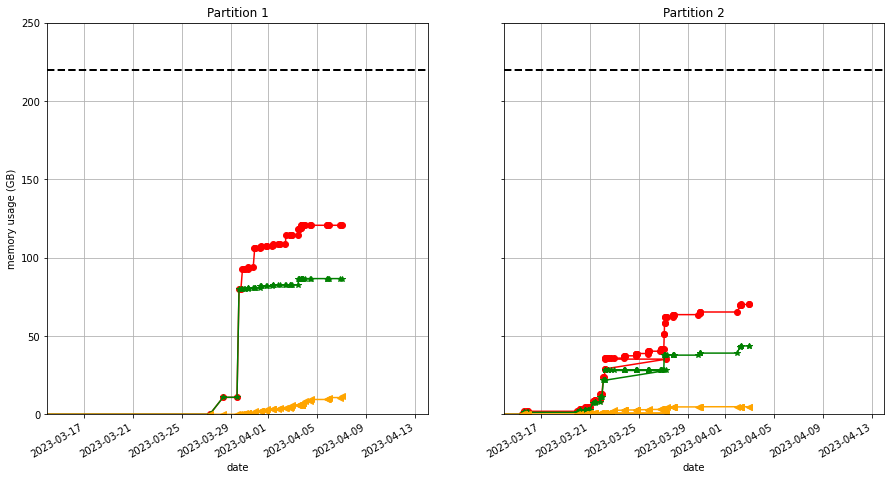

In [94]:
xlim = (DT(2023,3,14,0,0,0),DT(2023,4,14,0,0,0))
plot_tot(PHI, xlim=xlim, ylim=(0,250), time_ord=True)


/tmp/ipykernel_88733/542977430.py:217: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(times,newc1+newc2,color='black',linestyle='-',marker='.',label='total: '+str(round(total,1))+' GB')


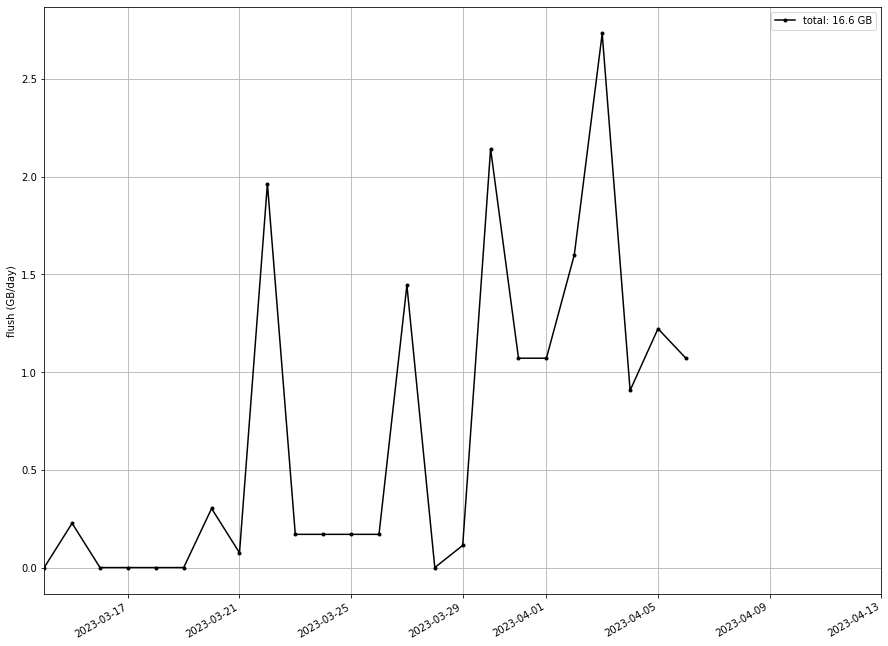

In [95]:
xlim = (DT(2023,3,14,0,0,0),DT(2023,4,13,0,0,0))
plot_flush_per_day(PHI,xlim)

We must empty partition 1 by April 10 to acquire the 6h QS SOOP

We can put almost everything in partition one from RSW 7 (so far RS-burst and Nanoflares1 in NAND 2)

# <span style="color:red">*RSW 8*</span>

## <span style="color:magenta">***RESET NAND 2***</span>

amount of compressed data + metadata in partition 2: 4.88 GB


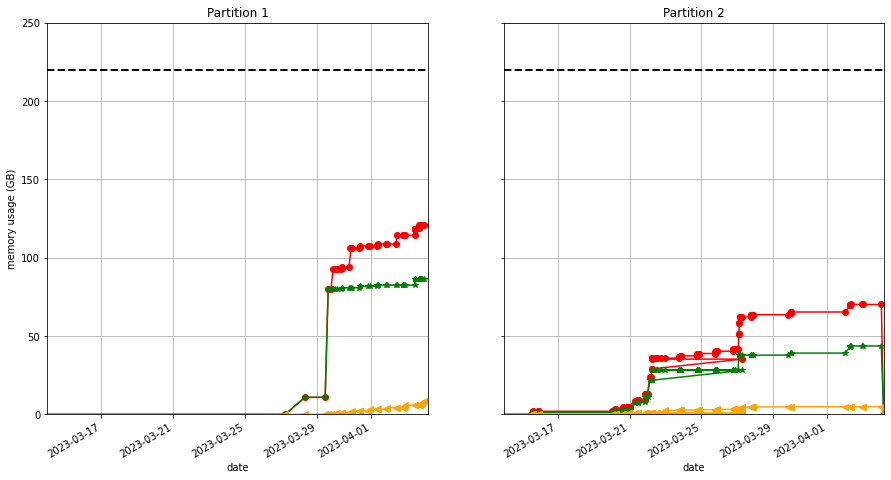

In [96]:
print('amount of compressed data + metadata in partition 2:',round(PHI.part2.compr*1e-3,2), 'GB')
PHI.format_partition(2,DT(2023,4,4,0,10,0))
xlim = (DT(2023,3,14,0,0,0),DT(2023,4,4,4,0,0))
plot_tot(PHI, xlim=xlim, ylim=(0,250), time_ord=True)


## <span style="color:blue">Nanoflares 2</span>

<span style="color:red">crop to 1536 px to save telemetry</span>

In [97]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-04-04T04:08:08')
t1 = DT.fromisoformat('2023-04-04T07:08:08')
nanohrt2 = PHI_MODE('HRT')
# nanofdt2 = PHI_MODE('FDT')
crop = 1408

# cadence 60s to 100s to get some telemetry for high cadence
kw = nanohrt2.observation(t0,18,cadence=100/6,shape=(2048,crop,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanohrt2.observation(t0+TD(minutes=30),3,cadence=60,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanohrt2.cropping(DT(2023,4,4,6,30,0),crop=crop,ndata=-1,level = 'raw');# phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanohrt2.packing(DT(2023,4,4,7,30,0),ndata=-1,level = 'raw.crop'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = nanofdt2.packing(DT(2023,4,4,8,30,0),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanohrt2.compressing(DT(2023,4,4,23,5,0),ndata=3,nbits=6,level = 'raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

kw = nanohrt2.compressing(DT(2023,4,12,22,0,0),ndata=6,nbits=6,level = 'raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanohrt2.compressing(DT(2023,4,13,22,0,0),ndata=6,nbits=6,level = 'raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanohrt2.compressing(DT(2023,4,14,22,0,0),ndata=6,nbits=6,level = 'raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
# nanohrt2, kw = flush_many(PHI,[600,600],72,nanohrt2,DT(2023,4,12,22,0,0),6,-1,'raw.pack',id)

########################################################
printp(nanohrt2, label='Nanoflares HRT 2')
# printp(nanofdt2, label='Nanoflares FDT 2')


Nanoflares HRT 2
number of datasets: 21
cadence: 60 mins
duration: 3:00:00
amount of raw-data at 32 bits: 6134.0 MiB, 292.1 MiB per dataset
crop size: 1408
amount of crop-data at 32 bits: 4005.4 MiB, 190.7 MiB per dataset
cropping time: 0:24:30
amount of pack-data at 16 bits: 2082.8 MiB, 99.2 MiB per dataset
packing time: 0:31:30
amount of compressed data + metadata at 6 bits: 714.8 MiB, 34.0 MiB per dataset
compressing (+ flushing) time: 1:39:56.483136
amount of metadata:  360.054 MiB
amount of memory usage: 12222.3 MiB



## <span style="color:blue">Bright Points</span>

In [98]:
########################################################
id = 1
t0 = DT.fromisoformat('2023-04-04T12:00:00')
t1 = DT.fromisoformat('2023-04-04T20:00:00')
BP = PHI_MODE('HRT')
crop = 1280

kw = BP.observation(t0,t1,cadence=30,shape=(2048,crop,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = BP.cropping(DT(2023,4,4,20,5),crop=crop,ndata=-1,level = 'raw');# phi.saving(id,**kw); PHI.saving(id,**kw)
kw = BP.packing(kw['end'],ndata=-1,level = 'raw.crop'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = BP.compressing(DT(2023,4,4,22,0),ndata=-1,nbits=6,level = 'raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

########################################################
printp(BP, label='Bright Points')


Bright Points
number of datasets: 16
cadence: 30 mins
duration: 8:00:00
amount of raw-data at 32 bits: 4028.3 MiB, 251.8 MiB per dataset
crop size: 1280
amount of crop-data at 32 bits: 2563.5 MiB, 160.2 MiB per dataset
cropping time: 0:18:40
amount of pack-data at 16 bits: 1342.8 MiB, 83.9 MiB per dataset
packing time: 0:24:00
amount of compressed data + metadata at 6 bits: 450.1 MiB, 28.1 MiB per dataset
compressing (+ flushing) time: 1:02:56.025600
amount of metadata:  384.144 MiB
amount of memory usage: 7934.6 MiB



## <span style="color:blue">Sunspot Oscillation</span>

<span style="color:red">cadence could be reduced to 60m to save telemetry</span>

In [99]:
########################################################
id = 1
t0 = DT.fromisoformat('2023-04-05T00:00:00')
t1 = DT.fromisoformat('2023-04-05T08:00:00')
SO = PHI_MODE('HRT')
crop = 1280

kw = SO.observation(t0,t1,cadence=30,shape=(2048,crop,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = SO.cropping(DT(2023,4,5,8,5),crop=crop,ndata=-1,level = 'raw');# phi.saving(id,**kw); PHI.saving(id,**kw)
kw = SO.packing(kw['end'],ndata=-1,level = 'raw.crop'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = SO.compressing(DT(2023,4,5,18,0,0),ndata=-1,nbits=6,level = 'raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

########################################################
printp(SO, label='Sunspot Oscillation')


Sunspot Oscillation
number of datasets: 16
cadence: 30 mins
duration: 8:00:00
amount of raw-data at 32 bits: 4028.3 MiB, 251.8 MiB per dataset
crop size: 1280
amount of crop-data at 32 bits: 2563.5 MiB, 160.2 MiB per dataset
cropping time: 0:18:40
amount of pack-data at 16 bits: 1342.8 MiB, 83.9 MiB per dataset
packing time: 0:24:00
amount of compressed data + metadata at 6 bits: 450.1 MiB, 28.1 MiB per dataset
compressing (+ flushing) time: 1:02:56.025600
amount of metadata:  384.144 MiB
amount of memory usage: 7934.6 MiB



## <span style="color:blue">Major Flare Watch (CANCELLED)</span>

<span style="color:red">HRT or FDT? What cadence?</span>

In [100]:
# ########################################################
# id = 1
# t0 = DT.fromisoformat('2023-04-05T09:00:00')
# t1 = DT.fromisoformat('2023-04-05T17:00:00')
# MFW = PHI_MODE('HRT')
# crop = 1280

# kw = MFW.observation(t0,t1,cadence=30,shape=(2048,crop,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = MFW.cropping(DT(2023,4,5,17,5),crop=crop,ndata=-1,level = 'raw');# phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = MFW.packing(kw['end'],ndata=-1,level = 'raw.crop'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = MFW.compressing(DT(2023,4,6,14,0,0),ndata=-1,nbits=6,level = 'raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

# ########################################################
# printp(MFW, label='Sunspot Oscillation')


## <span style="color:blue">Nanoflares 3 (CANCELLED)</span>

<span style="color:red">crop to 1536 px to save telemetry</span>

In [101]:
# ########################################################
# id = 2
# t0 = DT.fromisoformat('2023-04-06T02:00:00')
# t1 = DT.fromisoformat('2023-04-06T05:00:00')
# nanohrt3 = PHI_MODE('HRT')
# # nanofdt3 = PHI_MODE('FDT')
# crop = 1408

# # cadence 60s to 100s to get some telemetry for high cadence
# kw = nanohrt3.observation(t0,18,cadence=100/60,shape=(2048,crop,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = nanohrt3.observation(t0+TD(minutes=30),t1,cadence=60,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = nanohrt3.cropping(DT(2023,4,6,4,30,0),crop=crop,ndata=-1,level = 'raw');# phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = nanohrt3.packing(DT(2023,4,6,5,30,0),ndata=-1,level = 'raw.crop'); phi.saving(id,**kw); PHI.saving(id,**kw)
# # kw = nanofdt3.packing(DT(2023,4,6,6,30,0),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = nanohrt3.compressing(DT(2023,4,6,23,35,0),ndata=3,nbits=6,level = 'raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

# kw = nanohrt3.compressing(DT(2023,4,15,22,0,0),ndata=6,nbits=6,level = 'raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = nanohrt3.compressing(DT(2023,4,16,22,0,0),ndata=6,nbits=6,level = 'raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = nanohrt3.compressing(DT(2023,4,17,22,0,0),ndata=6,nbits=6,level = 'raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
# # nanohrt3, kw = flush_many(PHI,[600,600],72,nanohrt3,DT(2023,4,15,22,0,0),6,-1,'raw.pack',id)

# ########################################################
# printp(nanohrt3, label='Nanoflares HRT 3')
# # printp(nanofdt3, label='Nanoflares FDT 3')


## <span style="color:blue">RS-burst 2 (Sebas with Hardi's scheme)</span>

<span style="color:red">cadence reduced to 100s and crop to 1536 px to save telemetry</span>

In [102]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-04-06T08:00:00')
t1 = DT.fromisoformat('2023-04-06T11:30:00')
RShrt2 = PHI_MODE('HRT')
# RSfdt2 = PHI_MODE('FDT')
crop = 1408

kw = RShrt2.observation(t0,18,cadence=100/60,shape=(2048,crop,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RShrt2.observation(t0+TD(minutes=30),t1,cadence=60,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RShrt2.cropping(DT(2023,4,6,11,0,0),crop=crop,ndata=-1,level = 'raw');# phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RShrt2.packing(DT(2023,4,6,12,0,0),ndata=-1,level = 'raw.crop'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = RSfdt2.packing(DT(2023,4,6,13,0,0),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RShrt2.compressing(DT(2023,4,7,22,30,0),ndata=3,nbits=6,level = 'raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

kw = RShrt2.compressing(DT(2023,4,18,21,20,0),ndata=6,nbits=6,level = 'raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RShrt2.compressing(DT(2023,4,19,21,20,0),ndata=6,nbits=6,level = 'raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RShrt2.compressing(DT(2023,4,20,22,0,0),ndata=6,nbits=6,level = 'raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
# RShrt2, kw = flush_many(PHI,[1200,1200],72,RShrt2,DT(2023,4,18,22,0,0),6,-1,'raw.pack',id)

########################################################
printp(RShrt2, label='RS-burst HRT 2')
# printp(RSfdt2, label='RS-burst FDT 2')

RS-burst HRT 2
number of datasets: 21
cadence: 60 mins
duration: 3:00:00
amount of raw-data at 32 bits: 6134.0 MiB, 292.1 MiB per dataset
crop size: 1408
amount of crop-data at 32 bits: 4005.4 MiB, 190.7 MiB per dataset
cropping time: 0:24:30
amount of pack-data at 16 bits: 2082.8 MiB, 99.2 MiB per dataset
packing time: 0:31:30
amount of compressed data + metadata at 6 bits: 714.8 MiB, 34.0 MiB per dataset
compressing (+ flushing) time: 1:39:56.483136
amount of metadata:  360.054 MiB
amount of memory usage: 12222.3 MiB



## <span style="color:green">FDT Flat 3</span>

In [103]:
########################################################
id = 1

t0 = DT.fromisoformat('2023-04-06T18:00:00')
t1 = DT.fromisoformat('2023-04-06T19:00:00')
FDTflat3 = FDT_flat(PHI,t0,id,DT(2023,4,7,0,30,0),DT(2023,4,7,6,30,0),verbose=False)
########################################################
printp(FDTflat3, label="FDT FLAT 3 (06/04/2023)")

FDT FLAT 3 (06/04/2023)
number of datasets: 10
cadence: 300.0 mins
duration: 5:00:00
amount of raw-data at 32 bits: 3967.3 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 206.0 MiB, 206.0 MiB per dataset
packing time: 0:01:30
amount of compressed data + metadata at 6 bits: 72.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:10:04.051776
amount of metadata:  16.009 MiB
amount of memory usage: 4173.3 MiB



## <span style="color:blue">Coronal Dynamics 1</span>

In [104]:
########################################################
id = 1
t0 = DT.fromisoformat('2023-04-06T20:00:00')
t1 = DT.fromisoformat('2023-04-08T21:00:00')
CD1 = PHI_MODE('FDT')

synoptic_raw(PHI,CD1,t0,t1,360,(2048,2048,4,6),6,id)

########################################################
printp(CD1, label='Coronal Dynamics 1')


Coronal Dynamics 1
number of datasets: 8
cadence: 2 mins
duration: 0:02:00
amount of raw-data at 32 bits: 3173.8 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 1647.9 MiB, 206.0 MiB per dataset
packing time: 0:12:00
amount of compressed data + metadata at 6 bits: 576.1 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 1:20:32.414208
amount of metadata:  16.009 MiB
amount of memory usage: 4821.8 MiB



## <span style="color:blue">RS-burst 3 (MEREGED)</span>
Sebas SOOP

17 datasets, variable cadence, crop 1280

In [105]:
# ########################################################
# id = 2
# t0 = DT.fromisoformat('2023-04-07T17:30:00')
# t1 = DT.fromisoformat('2023-04-07T18:30:00')
# RS3 = PHI_MODE('HRT')
# crop = 1280

# kw = RS3.observation(t0,17,cadence=2,shape=(2048,crop,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = RS3.cropping(DT(2023,4,21,10,0,0),crop=crop,ndata=-1,level = 'raw');# phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = RS3.packing(DT(2023,4,21,11,0,0),ndata=-1,level = 'raw.crop'); phi.saving(id,**kw); PHI.saving(id,**kw)

# kw = RS3.compressing(DT(2023,4,21,22,0,0),ndata=9,nbits=6,level = 'raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = RS3.compressing(DT(2023,4,22,22,0,0),ndata=8,nbits=6,level = 'raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
# # RS3, kw = flush_many(PHI,[800,800],72,RS3,DT(2023,4,21,22,0,0),6,-1,'raw.pack',id); phi.saving(id,**kw); PHI.saving(id,**kw)

# ########################################################
# printp(RS3, label='Stereoscopy (Sebas)')


## <span style="color:blue">CH Bounday Expansion</span>

In [106]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-04-09T00:00:00')
t1 = DT.fromisoformat('2023-04-10T00:00:00')
CH1 = PHI_MODE('FDT')

synoptic_raw(PHI,CH1,t0,t1,360,(2048,2048,4,6),6,id)

########################################################
printp(CH1, label='CH boundary expansion')


CH boundary expansion
number of datasets: 4
cadence: 2 mins
duration: 0:02:00
amount of raw-data at 32 bits: 1586.9 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 824.0 MiB, 206.0 MiB per dataset
packing time: 0:06:00
amount of compressed data + metadata at 6 bits: 288.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:40:16.207104
amount of metadata:  16.009 MiB
amount of memory usage: 2410.9 MiB



## <span style="color:magenta">***RESET NAND 1***</span>

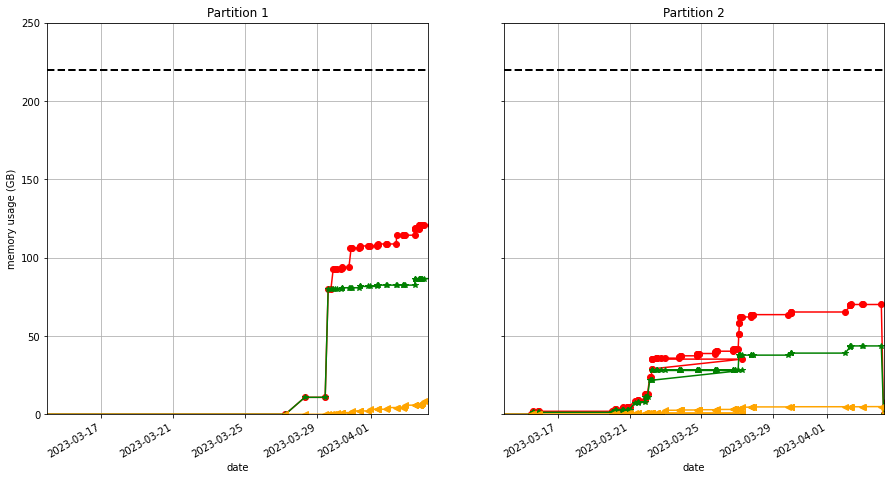

In [107]:
# print('amount of compressed data + metadata in partition 1:',round(PHI.part1.compr*1e-3,2), 'GB')
# PHI.format_partition(1,DT(2023,4,9,6,10,0))
# xlim = (DT(2023,3,14,0,0,0),DT(2023,4,25,0,0,0))
plot_tot(PHI, xlim=xlim, ylim=(0,250), time_ord=True)


## <span style="color:blue">Nanoflares 4</span>
6h QS, CROP+PACK

In [108]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-04-10T03:30:00')
t1 = DT.fromisoformat('2023-04-10T09:30:00')
QS = PHI_MODE('HRT')
crop = 1024

kw = QS.observation(t0,t1,cadence=1,shape=(2048,crop,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
for i in range(72):
    kw = QS.cropping(DT(2023,6,3,20,0,0)+TD(days=i),crop=crop,ndata=5,level = 'raw');# phi.saving(id,**kw); PHI.saving(id,**kw)
    kw = QS.packing(kw['end'],ndata=5,level = 'raw.crop'); phi.saving(id,**kw); PHI.saving(id,**kw)
    kw = QS.compressing(DT(2023,6,3,22,0,0)+TD(days=i),ndata=5,nbits=6,level = 'raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

# QS, kw = flush_many(PHI,[250,250],34,QS,DT(2023,6,3,22,0,0),6,-1,'raw.crop.pack',id)

########################################################
printp(QS, label='Nanoflares QS')


Nanoflares QS
number of datasets: 360
cadence: 1 mins
duration: 6:00:00
amount of raw-data at 32 bits: 74157.7 MiB, 206.0 MiB per dataset
crop size: 1024
amount of crop-data at 32 bits: 38452.1 MiB, 106.8 MiB per dataset
cropping time: 3:30:00
amount of pack-data at 16 bits: 21972.7 MiB, 61.0 MiB per dataset
packing time: 4:30:00
amount of compressed data + metadata at 6 bits: 6483.1 MiB, 18.0 MiB per dataset
compressing (+ flushing) time: 15:06:24.099840
amount of metadata:  2960.045 MiB
amount of memory usage: 134582.5 MiB



## <span style="color:blue">RS-burst 4</span>

<span style="color:red">crop to 1536 px and cadence to 100s to save telemetry</span>

In [109]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-04-10T20:00:00')
t1 = DT.fromisoformat('2023-04-10T23:30:00')
RShrt4 = PHI_MODE('HRT')
# RSfdt4 = PHI_MODE('FDT')
crop = 1408

kw = RShrt4.observation(t0,30,cadence=1,shape=(2048,crop,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RShrt4.observation(t0+TD(minutes=30),t1,cadence=60,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RShrt4.cropping(DT(2023,4,10,11,0,0),crop=crop,ndata=-1,level = 'raw');# phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RShrt4.packing(DT(2023,4,10,12,0,0),ndata=-1,level = 'raw.crop'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = RSfdt4.packing(DT(2023,4,10,13,0,0),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = RShrt4.compressing(DT(2023,4,10,22,30,0),ndata=-1,nbits=6,level = 'raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
# RShrt4, kw = flush_many(PHI,[800,800],72,RShrt4,DT(2023,4,26,22,0,0),6,-1,'raw.pack',id)
for i in range(10):
    kw = RShrt4.compressing(DT(2023,4,28,22,0,0)+TD(days=i),ndata=3,nbits=6,level = 'raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

# RShrt4, kw = flush_many(PHI,[300,300],72,RShrt4,DT(2023,5,3,22,0,0),6,-1,'raw.pack',id)

########################################################
printp(RShrt4, label='RS-burst HRT 4')
# printp(RSfdt4, label='RS-burst FDT 4')

RS-burst HRT 4
number of datasets: 33
cadence: 60 mins
duration: 3:00:00
amount of raw-data at 32 bits: 9429.9 MiB, 285.8 MiB per dataset
crop size: 1408
amount of crop-data at 32 bits: 6294.3 MiB, 190.7 MiB per dataset
cropping time: 0:38:30
amount of pack-data at 16 bits: 3273.0 MiB, 99.2 MiB per dataset
packing time: 0:49:30
amount of compressed data + metadata at 6 bits: 1021.2 MiB, 34.0 MiB per dataset
compressing (+ flushing) time: 2:22:46.404480
amount of metadata:  552.027 MiB
amount of memory usage: 18997.2 MiB



## <span style="color:blue">Nanoflares 4.5</span>
crop 1536 and 100s cadence, CROP+PACK

In [14]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-04-11T21:04:00')
t1 = DT.fromisoformat('2023-04-12T00:05:00')
nanohrt45 = PHI_MODE('HRT')
# nanofdt45 = PHI_MODE('FDT')
crop = 2048

kw = nanohrt45.observation(t0,18,cadence=100/60,shape=(2048,crop,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanohrt45.observation(t0,t1,cadence=60,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = nanohrt45.cropping(DT(2023,4,12,7,0,0),crop=crop,ndata=-1,level = 'raw');# phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanohrt45.packing(kw['end'],ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = nanofdt45.packing(DT(2023,5,1,13,0,0),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanohrt45.compressing(DT(2023,4,15,22,0,0),ndata=3,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanohrt45.compressing(DT(2023,4,16,22,0,0),ndata=2,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanohrt45.compressing(DT(2023,4,17,22,0,0),ndata=2,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

kw = nanohrt45.compressing(DT(2023,5,8,22,0,0),ndata=2,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanohrt45.compressing(DT(2023,5,9,22,0,0),ndata=2,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanohrt45.compressing(DT(2023,5,10,22,0,0),ndata=2,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanohrt45.compressing(DT(2023,5,11,22,0,0),ndata=2,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanohrt45.compressing(DT(2023,5,12,22,30,0),ndata=2,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanohrt45.compressing(DT(2023,5,13,22,30,0),ndata=2,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanohrt45.compressing(DT(2023,5,14,22,30,0),ndata=2,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

# nanohrt45, kw = flush_many(PHI,[250,250],40.5,nanohrt45,DT(2023,5,13,22,0,0),6,-1,'raw.crop.pack',id)

########################################################
printp(nanohrt45, label='Nanoflares HRT 4.5')
# printp(nanofdt45, label='Nanoflares FDT 4.5')


Nanoflares HRT 4.5
number of datasets: 21
cadence: 60 mins
duration: 3:01:00
amount of raw-data at 32 bits: 8331.3 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 4325.9 MiB, 206.0 MiB per dataset
packing time: 0:31:30
amount of compressed data + metadata at 6 bits: 1512.2 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 3:31:25.087296
amount of metadata:  192.018 MiB
amount of memory usage: 12657.2 MiB



## <span style="color:green">HRT Flat 3</span>

In [111]:
########################################################
id = 2

t0 = DT.fromisoformat('2023-04-11T12:00:00')
t1 = DT.fromisoformat('2023-04-11T22:00:00')
HRTflat2 = HRT_flat(PHI,t0,id,verbose=False)
########################################################
printp(HRTflat1, label="HRT FLAT 3 (11/04/2023)")

HRT FLAT 3 (11/04/2023)
number of datasets: 11
cadence: 15.0 mins
duration: 0:15:00
amount of raw-data at 32 bits: 4364.0 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 206.0 MiB, 206.0 MiB per dataset
packing time: 0:01:30
amount of compressed data + metadata at 6 bits: 72.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:10:04.051776
amount of metadata:  16.009 MiB
amount of memory usage: 4570.0 MiB



## <span style="color:blue">Density Fluctuations</span>

In [112]:
########################################################10
id = 1
t0 = DT.fromisoformat('2023-04-12T00:00:00')
t1 = DT.fromisoformat('2023-04-15T00:00:00')
DF = PHI_MODE('FDT')

synoptic_raw(PHI,DF,t0,t1,360,(2048,2048,4,6),6,id)

########################################################
printp(DF, label='Density Fluctuations')


Density Fluctuations
number of datasets: 12
cadence: 2 mins
duration: 0:02:00
amount of raw-data at 32 bits: 4760.7 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 2471.9 MiB, 206.0 MiB per dataset
packing time: 0:18:00
amount of compressed data + metadata at 6 bits: 864.1 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 2:00:48.621312
amount of metadata:  16.009 MiB
amount of memory usage: 7232.7 MiB



## <span style="color:green">FDT Flat 4</span>

In [114]:
########################################################
id = 2

t0 = DT.fromisoformat('2023-04-15T00:00:00')
t1 = DT.fromisoformat('2023-04-15T01:00:00')
FDTflat4 = FDT_flat(PHI,t0,id,flush=DT(2023,4,15,20,15),verbose=False)
kw = FDTflat4.packing(DT(2023,4,15,19,35,0),ndata=9,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = FDTflat4.compressing(DT(2023,4,15,20,25),ndata=9,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

########################################################
printp(FDTflat2, label="FDT FLAT 4 (15/04/2023)")

FDT FLAT 4 (15/04/2023)
number of datasets: 10
cadence: 300.0 mins
duration: 5:00:00
amount of raw-data at 32 bits: 3967.3 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 2059.9 MiB, 206.0 MiB per dataset
packing time: 0:15:00
amount of compressed data + metadata at 6 bits: 720.1 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 1:40:40.517760
amount of metadata:  80.081 MiB
amount of memory usage: 6027.2 MiB



## <span style="color:blue">Nanoflares 5</span>

<span style="color:red">crop to 1536 px and cadence to 100s to save telemetry</span>

In [113]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-04-15T02:00:00')
t1 = DT.fromisoformat('2023-04-15T05:00:00')
nanohrt5 = PHI_MODE('HRT')
# nanofdt5 = PHI_MODE('FDT')
crop = 1408

kw = nanohrt5.observation(t0,18,cadence=100/60,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanohrt5.observation(t0+TD(minutes=30),t1,cadence=60,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanohrt5.cropping(DT(2023,4,15,4,30,0),crop=crop,ndata=-1,level = 'raw');# phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanohrt5.packing(DT(2023,4,15,5,30,0),ndata=-1,level = 'raw.crop'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = nanofdt5.packing(DT(2023,4,15,6,30,0),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = nanohrt5.compressing(DT(2023,4,15,21,55,0),ndata=3,nbits=6,level = 'raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
# nanohrt5, kw = flush_many(PHI,[1200,1200],72,nanohrt5,DT(2023,4,15,22,0,0),6,-1,'raw.pack',id)
for i in range(7):
    kw = nanohrt5.compressing(DT(2023,5,15,22,0,0)+TD(days=i),ndata=3,nbits=6,level = 'raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

# nanohrt3, kw = flush_many(PHI,[300,300],72,nanohrt5,DT(2023,5,20,22,0,0),6,-1,'raw.pack',id)

########################################################
printp(nanohrt5, label='Nanoflares HRT 5')
# printp(nanofdt5, label='Nanoflares FDT 5')


2023-05-20 22:00:00 WARNING: Compression, Exceeding the number of datasets, max should be 2
Nanoflares HRT 5
number of datasets: 20
cadence: 60 mins
duration: 2:30:00
amount of raw-data at 32 bits: 7934.6 MiB, 396.7 MiB per dataset
crop size: 1408
amount of crop-data at 32 bits: 3814.7 MiB, 190.7 MiB per dataset
cropping time: 0:23:20
amount of pack-data at 16 bits: 1983.6 MiB, 99.2 MiB per dataset
packing time: 0:30:00
amount of compressed data + metadata at 6 bits: 714.8 MiB, 34.0 MiB per dataset
compressing (+ flushing) time: 1:39:56.483136
amount of metadata:  336.027 MiB
amount of memory usage: 13732.9 MiB



## <span style="color:blue">Connection Mosaic 2</span>

In [115]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-04-15T16:00:00')
t1 = DT.fromisoformat('2023-04-17T16:18:51')
CM2 = PHI_MODE('HRT')

synoptic_raw(PHI,CM2,t0,t1,240,(2048,2048,4,6),6,id)

########################################################
printp(CM2, label='Connection Mosaic 2')


Connection Mosaic 2
number of datasets: 12
cadence: 2 mins
duration: 0:02:00
amount of raw-data at 32 bits: 4760.7 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 2471.9 MiB, 206.0 MiB per dataset
packing time: 0:18:00
amount of compressed data + metadata at 6 bits: 864.1 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 2:00:48.621312
amount of metadata:  16.009 MiB
amount of memory usage: 7232.7 MiB



## <span style="color:green">HRT Flat 4</span>

In [116]:
########################################################
id = 2

t0 = DT.fromisoformat('2023-04-18T00:00:00')
t1 = DT.fromisoformat('2023-04-18T10:00:00')
HRTflat4 = HRT_flat(PHI,t0,id,flush=DT(2023,4,18,23,0,0),verbose=False)
########################################################
printp(HRTflat4, label="HRT FLAT 4 (16/04/2023)")

HRT FLAT 4 (16/04/2023)
number of datasets: 11
cadence: 15.0 mins
duration: 0:15:00
amount of raw-data at 32 bits: 4364.0 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 206.0 MiB, 206.0 MiB per dataset
packing time: 0:01:30
amount of compressed data + metadata at 6 bits: 72.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:10:04.051776
amount of metadata:  16.009 MiB
amount of memory usage: 4570.0 MiB



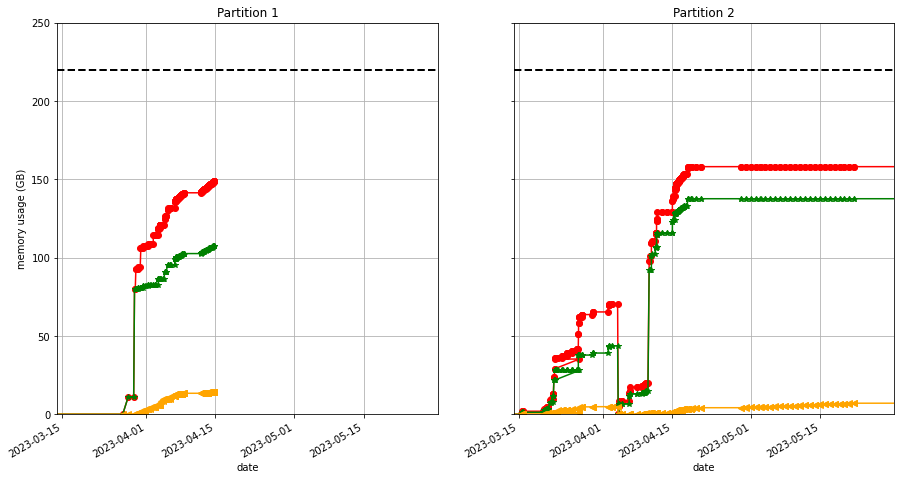

In [117]:
xlim = (DT(2023,3,14,0,0,0),DT(2023,5,30,0,0,0))
plot_tot(PHI, xlim=xlim, ylim=(0,250), time_ord=True)


/tmp/ipykernel_88733/542977430.py:217: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(times,newc1+newc2,color='black',linestyle='-',marker='.',label='total: '+str(round(total,1))+' GB')


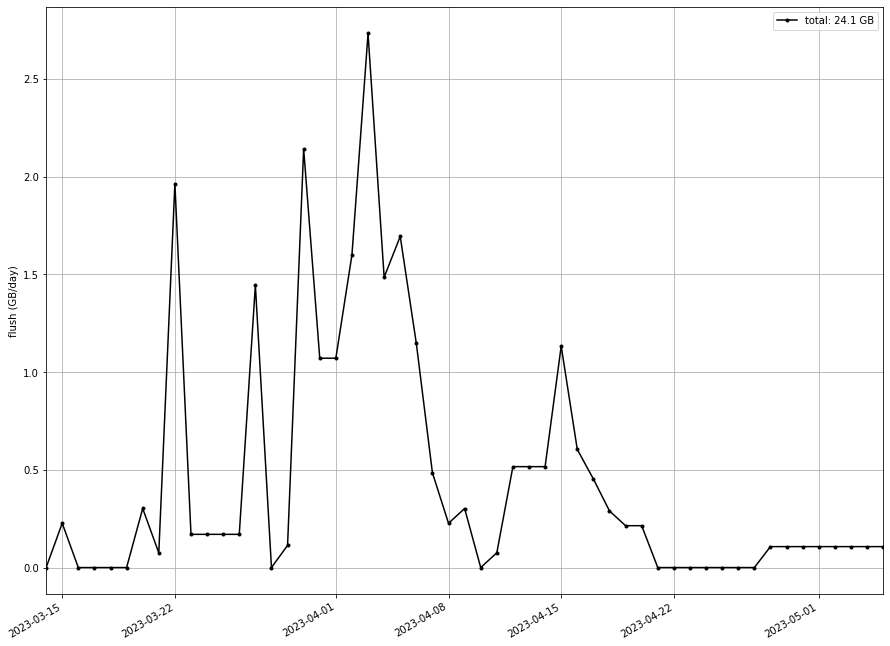

In [118]:
xlim = (DT(2023,3,14,0,0,0),DT(2023,5,5,0,0,0))
plot_flush_per_day(PHI,xlim)

# <span style="color:magenta">*RSW 9*</span>

## <span style="color:blue">Coronal Dynamics 2</span>

In [119]:
########################################################
id = 1
t0 = DT.fromisoformat('2023-04-20T00:00:00')
t1 = DT.fromisoformat('2023-04-21T00:00:00')
CD2 = PHI_MODE('FDT')

synoptic_raw(PHI,CD2,t0,t1,120,(2048,1664,4,6),6,id)

########################################################
printp(CD2, label='Coronal Dynamics 2')


Coronal Dynamics 2
number of datasets: 12
cadence: 2 mins
duration: 0:02:00
amount of raw-data at 32 bits: 3845.2 MiB, 320.4 MiB per dataset
crop size: 1664
amount of crop-data at 32 bits: 3204.3 MiB, 267.0 MiB per dataset
cropping time: 0:14:00
amount of pack-data at 16 bits: 1647.9 MiB, 137.3 MiB per dataset
packing time: 0:18:00
amount of compressed data + metadata at 6 bits: 570.5 MiB, 47.5 MiB per dataset
compressing (+ flushing) time: 1:19:45.516288
amount of metadata:  24.009 MiB
amount of memory usage: 8697.5 MiB



## <span style="color:blue">Slow Wind Connection 2</span>

<span style="color:red">crop or lower cadence to save telemetry</span>

2 datasets per day, one beginning and one end of EUI burst


In [120]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-04-21T06:45:00')
t1 = DT.fromisoformat('2023-04-24T21:00:00')
SW2 = PHI_MODE('HRT')

kw = SW2.observation(t0,2,cadence=60,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = SW2.packing(kw['end']+TD(minutes=10),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = SW2.compressing(kw['end']+TD(minutes=10),ndata=-1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = SW2.compressing(kw['end']+TD(minutes=10),ndata=2,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

kw = SW2.observation(t0+TD(days=1),2,cadence=60,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = SW2.packing(kw['end']+TD(minutes=10),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = SW2.compressing(kw['end']+TD(minutes=10),ndata=-1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = SW2.compressing(kw['end']+TD(minutes=10),ndata=2,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

kw = SW2.observation(t0+TD(days=2),2,cadence=60,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = SW2.packing(kw['end']+TD(minutes=10),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = SW2.compressing(kw['end']+TD(minutes=10),ndata=-1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = SW2.compressing(kw['end']+TD(minutes=10),ndata=2,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

kw = SW2.observation(t0+TD(days=3),2,cadence=60,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = SW2.packing(kw['end']+TD(minutes=10),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = SW2.compressing(kw['end']+TD(minutes=10),ndata=-1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = SW2.compressing(kw['end']+TD(minutes=10),ndata=2,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

# kw = SW2.compressing(DT(2023,4,25,22,0,0),ndata=2,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = SW2.compressing(DT(2023,4,26,22,0,0),ndata=2,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = SW2.compressing(DT(2023,4,27,22,0,0),ndata=2,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = SW2.compressing(DT(2023,4,28,22,0,0),ndata=4,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = SW2.compressing(DT(2023,4,29,22,0,0),ndata=4,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = SW2.compressing(DT(2023,4,30,22,0,0),ndata=4,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = SW2.compressing(DT(2023,5,1,22,0,0),ndata=4,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = SW2.compressing(DT(2023,5,2,22,0,0),ndata=4,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

########################################################
printp(SW2, label='Slow Wind Connection 2')


Slow Wind Connection 2
number of datasets: 8
cadence: 60 mins
duration: 2:00:00
amount of raw-data at 32 bits: 3173.8 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 1647.9 MiB, 206.0 MiB per dataset
packing time: 0:12:00
amount of compressed data + metadata at 6 bits: 576.1 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 1:20:32.414208
amount of metadata:  32.018 MiB
amount of memory usage: 4821.8 MiB



## <span style="color:blue">Polar Observations 2</span>

In [121]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-04-24T21:00:00')
t1 = DT.fromisoformat('2023-04-25T00:00:00')
polar2 = PHI_MODE('HRT')

kw = polar2.observation(t0,12,cadence=5,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = polar2.packing(kw['end']+TD(minutes=10),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = polar2.compressing(DT(2023,5,22,22,0,0),ndata=1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = polar2.compressing(DT(2023,5,23,22,0,0),ndata=1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = polar2.compressing(DT(2023,5,24,22,0,0),ndata=1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = polar2.compressing(DT(2023,5,25,22,0,0),ndata=1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = polar2.compressing(DT(2023,5,26,22,0,0),ndata=1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = polar2.compressing(DT(2023,5,27,22,0,0),ndata=1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = polar2.compressing(DT(2023,5,28,22,0,0),ndata=1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = polar2.compressing(DT(2023,5,29,22,0,0),ndata=1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = polar2.compressing(DT(2023,5,30,22,0,0),ndata=1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = polar2.compressing(DT(2023,5,31,22,0,0),ndata=1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = polar2.compressing(DT(2023,6,1,22,0,0),ndata=1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = polar2.compressing(DT(2023,6,2,22,0,0),ndata=1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

########################################################
printp(polar2, label='Polar observations 2')


Polar observations 2
number of datasets: 12
cadence: 5 mins
duration: 1:00:00
amount of raw-data at 32 bits: 4760.7 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 2471.9 MiB, 206.0 MiB per dataset
packing time: 0:18:00
amount of compressed data + metadata at 6 bits: 864.1 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 2:00:48.621312
amount of metadata:  192.009 MiB
amount of memory usage: 7232.7 MiB



# <span style="color:white">*out of RSWs*</span>

## <span style="color:green">FDT Flat 5</span>

In [122]:
########################################################
id = 2

t0 = DT.fromisoformat('2023-04-25T10:00:00')
t1 = DT.fromisoformat('2023-04-25T11:00:00')
FDTflat3 = FDT_flat(PHI,t0,id,DT(2023,4,26,1,0,0),verbose=False)
########################################################
printp(FDTflat3, label="FDT FLAT 5 (06/04/2023)")

FDT FLAT 5 (06/04/2023)
number of datasets: 10
cadence: 300.0 mins
duration: 5:00:00
amount of raw-data at 32 bits: 3967.3 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 206.0 MiB, 206.0 MiB per dataset
packing time: 0:01:30
amount of compressed data + metadata at 6 bits: 72.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:10:04.051776
amount of metadata:  16.009 MiB
amount of memory usage: 4173.3 MiB



## <span style="color:green">HRT Flat 5</span>

In [123]:
########################################################
id = 2

t0 = DT.fromisoformat('2023-04-25T11:00:00')
t1 = DT.fromisoformat('2023-04-25T21:00:00')
HRTflat5 = HRT_flat(PHI,t0,id,verbose=False)
########################################################
printp(HRTflat4, label="HRT FLAT 5 (25/04/2023)")

HRT FLAT 5 (25/04/2023)
number of datasets: 11
cadence: 15.0 mins
duration: 0:15:00
amount of raw-data at 32 bits: 4364.0 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 206.0 MiB, 206.0 MiB per dataset
packing time: 0:01:30
amount of compressed data + metadata at 6 bits: 72.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:10:04.051776
amount of metadata:  16.009 MiB
amount of memory usage: 4570.0 MiB



## <span style="color:green">Synoptic</span>

CROP+PACK

<span style="color:red">cadence to 4h to save telemetry</span>

In [9]:
# ########################################################
# id = 2
# t0 = DT.fromisoformat('2023-04-26T00:00:00')
# t1 = DT.fromisoformat('2023-05-04T00:00:00')
# DF = PHI_MODE('FDT')

# synoptic_raw(PHI,DF,t0,t1,240,(2048,1280,4,6),6,id,crop_pack=True)

# ########################################################
# printp(DF, label='Synoptic')

########################################################
id = 2
t0 = DT.fromisoformat('2023-04-26T00:00:00')
t1 = DT.fromisoformat('2023-05-02T00:00:00')
DF = PHI_MODE('FDT')
kw = DF.observation(t0,t1,360,(2048,1408,4,6)); PHI.saving(2,**kw)

t0 = DT.fromisoformat('2023-05-02T00:00:00')
t1 = DT.fromisoformat('2023-05-15T00:00:00')
DF = PHI_MODE('FDT')

kw = DF.observation(t0,t1,360,(2048,1280,4,6)); PHI.saving(2,**kw)

t0 = DT.fromisoformat('2023-05-15T00:00:00')
t1 = DT.fromisoformat('2023-05-24T00:00:00')
DF = PHI_MODE('FDT')

kw = DF.observation(t0,t1,360,(2048,1024,4,6)); PHI.saving(2,**kw)

t0 = DT.fromisoformat('2023-05-24T00:00:00')
t1 = DT.fromisoformat('2023-06-16T00:00:00')
DF = PHI_MODE('FDT')

kw = DF.observation(t0,t1,360,(2048,896,4,6)); PHI.saving(2,**kw)

t0 = DT.fromisoformat('2023-06-16T00:00:00')
t1 = DT.fromisoformat('2023-08-06T00:00:00')
DF = PHI_MODE('FDT')

kw = DF.observation(t0,t1,360,(2048,768,4,6),); PHI.saving(2,**kw)

t0 = DT.fromisoformat('2023-08-06T00:00:00')
t1 = DT.fromisoformat('2023-08-26T00:00:00')
DF = PHI_MODE('FDT')

kw = DF.observation(t0,t1,360,(2048,896,4,6),); PHI.saving(2,**kw)

t0 = DT.fromisoformat('2023-08-26T00:00:00')
t1 = DT.fromisoformat('2023-09-06T00:00:00')
DF = PHI_MODE('FDT')

kw = DF.observation(t0,t1,360,(2048,1024,4,6),); PHI.saving(2,**kw)

t0 = DT.fromisoformat('2023-09-06T00:00:00')
t1 = DT.fromisoformat('2023-09-18T00:00:00')
DF = PHI_MODE('FDT')

kw = DF.observation(t0,t1,360,(2048,1280,4,6)); PHI.saving(2,**kw)

t0 = DT.fromisoformat('2023-09-18T00:00:00')
t1 = DT.fromisoformat('2023-09-23T00:00:00')
DF = PHI_MODE('FDT')

kw = DF.observation(t0,t1,360,(2048,1408,4,6)); PHI.saving(2,**kw)
########################################################
printp(DF, label='Synoptic')

Synoptic
number of datasets: 20
cadence: 360 mins
duration: 5 days, 0:00:00
amount of raw-data at 32 bits: 5493.2 MiB, 274.7 MiB per dataset
amount of metadata:  160 MiB
amount of memory usage: 5493.2 MiB



## <span style="color:green">Synoptic</span>

3h cadence

In [43]:
# ########################################################
# id = 2
# t0 = DT.fromisoformat('2023-05-04T04:00:00')
# t1 = DT.fromisoformat('2023-05-20T00:00:00')
# DF = PHI_MODE('FDT')
# crop = 1536

# synoptic_raw(PHI,DF,t0,t1,240,(2048,crop,4,6),6,id)

# ########################################################
# printp(DF, label='Synoptic')


Synoptic
number of datasets: 95
cadence: 2 mins
duration: 0:02:00
amount of raw-data at 32 bits: 17395.0 MiB, 183.1 MiB per dataset
crop size: 896
amount of crop-data at 32 bits: 7972.7 MiB, 83.9 MiB per dataset
cropping time: 0:55:25
amount of processed data (and intermediate data) at 16 bits: 1449.6 MiB, 15.3 MiB per dataset
processing time: 2 days, 7:25:00
amount of compressed data + metadata at 6 bits: 188.1 MiB, 2.0 MiB per dataset
compressing (+ flushing) time: 0:26:18.015360
amount of metadata:  24.27 MiB
amount of memory usage: 26817.3 MiB



## <span style="color:magenta">***RESET NAND 2***</span>

In [126]:
# print('amount of compressed data + metadata in partition 2:',round(PHI.part2.compr*1e-3,2), 'GB')
# PHI.format_partition(2,DT(2023,5,20,0,10,0))

In [127]:
# ########################################################
# id = 2
# t0 = DT.fromisoformat('2023-05-20T04:00:00')
# t1 = DT.fromisoformat('2023-08-02T00:00:00')
# DF = PHI_MODE('FDT')

# synoptic_raw(PHI,DF,t0,t1,240,(2048,1024,4,6),6,id)

# ########################################################
# printp(DF, label='Synoptic')


# <span style="color:yellow">PLOTS</span>

We should try to format partition two at some point, in this way we could add more FDT synoptic during and after RSWs.

Implementing CROP+Pack would save ~70 GB of memory in NAND1

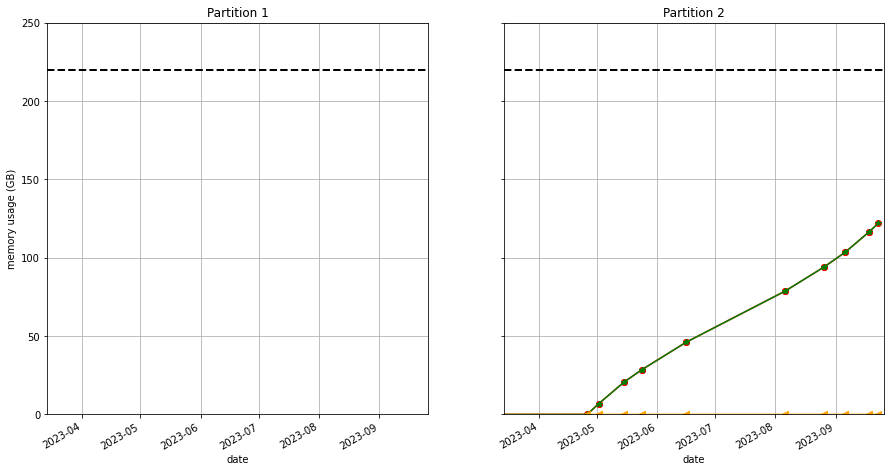

In [10]:
xlim = (DT(2023,3,14,0,0,0),DT(2023,9,26,0,0,0))
plot_tot(PHI, xlim=xlim, ylim=(0,250), time_ord=True)
# plt.savefig('/home/calchetti/MPStemp/pics/TM/total_v5.1.png')

# fname = '/home/calchetti/MPStemp/PHI_TMtool/TM_NMP1_v2.csv'
# PHI.save(fname)

/tmp/ipykernel_88733/542977430.py:217: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(times,newc1+newc2,color='black',linestyle='-',marker='.',label='total: '+str(round(total,1))+' GB')


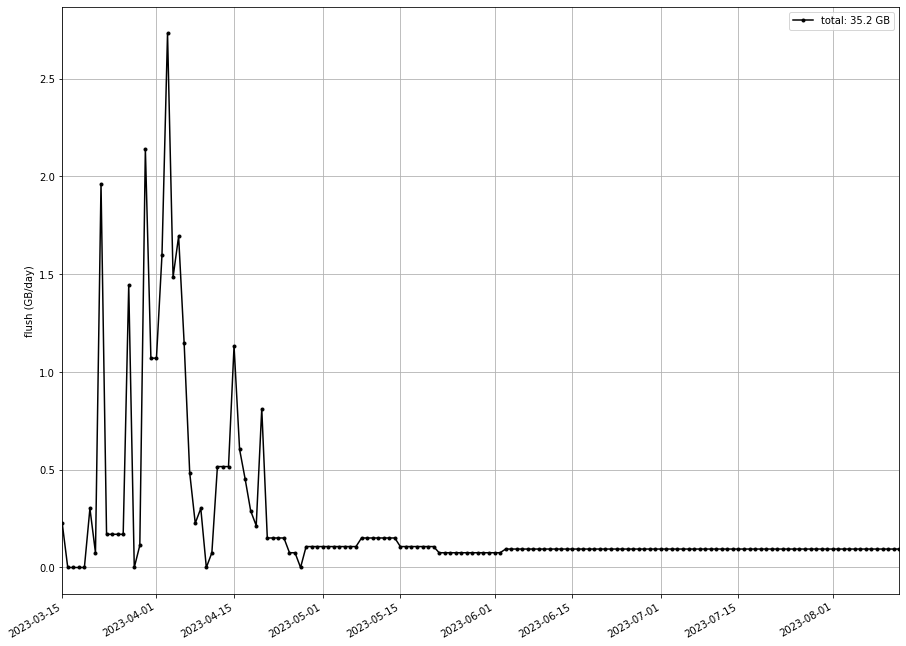

In [129]:
xlim = (DT(2023,3,15,0,0,0),DT(2023,8,13,0,0,0))
tt, tm1, tm2 = plot_flush_per_day(PHI,xlim,values=True)
# 1 GB = 2.2h of flushing

In [130]:
print('DATE\tFLUSH NAND-1 (MiB)\tFLUSH NAND-2 (MiB)')
for tti, tm1i, tm2i in zip(tt,tm1,tm2):
    print(str(tti)+'\t'+'{:.0f}'.format(tm1i*1e9/2**20)+'\t'+'{:.0f}'.format(tm2i*1e9/2**20))

DATE	FLUSH NAND-1 (MiB)	FLUSH NAND-2 (MiB)
2023-02-08	0	0
2023-02-09	0	0
2023-02-10	0	0
2023-02-11	0	0
2023-02-12	0	0
2023-02-13	0	0
2023-02-14	1412	0
2023-02-15	1412	0
2023-02-16	1412	0
2023-02-17	1412	0
2023-02-18	1412	0
2023-02-19	254	0
2023-02-20	0	0
2023-02-21	0	0
2023-02-22	0	1412
2023-02-23	0	1412
2023-02-24	0	1412
2023-02-25	0	1412
2023-02-26	0	1412
2023-02-27	0	254
2023-02-28	0	0
2023-03-01	0	0
2023-03-02	0	0
2023-03-03	0	0
2023-03-04	0	0
2023-03-05	0	0
2023-03-06	0	0
2023-03-07	0	0
2023-03-08	0	0
2023-03-09	0	0
2023-03-10	0	0
2023-03-11	0	0
2023-03-12	0	0
2023-03-13	0	0
2023-03-14	0	0
2023-03-15	0	216
2023-03-16	0	0
2023-03-17	0	0
2023-03-18	0	0
2023-03-19	0	0
2023-03-20	0	288
2023-03-21	0	72
2023-03-22	0	1872
2023-03-23	0	162
2023-03-24	0	162
2023-03-25	0	162
2023-03-26	0	162
2023-03-27	0	1377
2023-03-28	0	0
2023-03-29	0	108
2023-03-30	2042	0
2023-03-31	1021	0
2023-04-01	1021	0
2023-04-02	1453	72
2023-04-03	2605	0
2023-04-04	1314	102
2023-04-05	1615	0
2023-04-06	1093	0
2023-

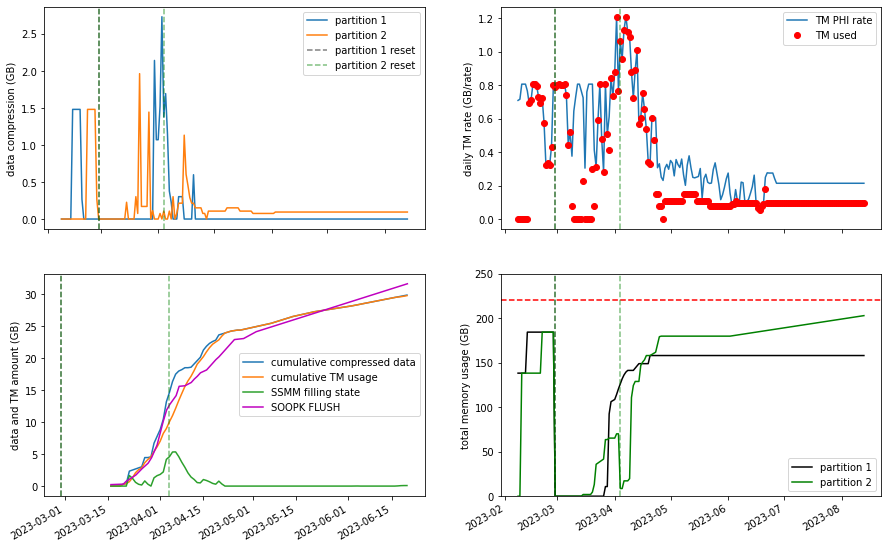

In [131]:
from scipy.interpolate import interp1d
tot1 = np.asarray(PHI.part1.history['occu'])
tot2 = np.asarray(PHI.part2.history['occu'])
c1 = np.asarray(PHI.part1.history['compr'])
c2 = np.asarray(PHI.part2.history['compr'])
d1 = np.asarray(PHI.part1.history['start'])
d2 = np.asarray(PHI.part2.history['start'])

starttime = min(min(d1),min(d2))
endtime = max(max(d1),max(d2))
t0 = starttime
times = []
while starttime.date() <= endtime.date():
    times.append(starttime.date())
    starttime += TD(days=1)
starttime = t0; del t0
times_float = [(t - d1[0]).total_seconds() for t in d1]
times = np.asarray(times)

s = np.argsort(d1)

newtot1 = np.zeros(np.size(times))
for i,j in zip(d1,tot1):
    if True:
        ind = np.where(times == i.date())[0]
        newtot1[ind] += j/1e3
newtot1 = np.asarray(newtot1)

newtot2 = np.zeros(np.size(times))
for i,j in zip(d2,tot2):
    if True:
        ind = np.where(times == i.date())[0]
        newtot2[ind] += j/1e3
newtot2 = np.asarray(newtot2)

newc1 = np.zeros(np.size(times))
for i,j in zip(d1,c1):
    if j>=0:
        ind = np.where(times == i.date())[0]
        newc1[ind] += j/1e3
newc1 = np.asarray(newc1)


newc2 = np.zeros(np.size(times))
for i,j in zip(d2,c2):
    if j>=0:
        ind = np.where(times == i.date())[0]
        newc2[ind] += j/1e3
newc2 = np.asarray(newc2)

form1 = np.zeros(np.size(times))
for i,j in zip(d1,c1):
    if j<0:
        ind = np.where(times == i.date())[0]
        form1[ind] += j/1e3
form1 = np.asarray(form1)


form2 = np.zeros(np.size(times))
for i,j in zip(d2,c2):
    if j<0:
        ind = np.where(times == i.date())[0]
        form2[ind] += j/1e3
form2 = np.asarray(form2)

trig1 = np.where(form1 < 0)[0]
trig2 = np.where(form2 < 0)[0]

x = TM3['date'][np.logical_and(TM3['date'] <= endtime+TD(days=1),TM3['date'] >= starttime-TD(days=1))]
y = TM3['tm_rate'][np.logical_and(TM3['date'] <= endtime+TD(days=1),TM3['date'] >= starttime-TD(days=1))]
z = TM3['duration'][np.logical_and(TM3['date'] <= endtime+TD(days=1),TM3['date'] >= starttime-TD(days=1))]

xx = [(i - starttime).total_seconds() for i in x]
f = interp1d(xx, y*z,fill_value='extrapolate')
xnew = [(i - starttime.date()).total_seconds() for i in times]
ynew = f(xnew)/8e9
ynew[times<datetime.date(2023,4,1)] *= .2
ynew[times>=datetime.date(2023,4,1)] *= .3

tm_used = np.zeros(times.size)
down = 0#np.zeros(times.size)
for i in range(times.size):
    if newc1[i] > 0 or newc2[i] > 0:
        tm_used[i] = min(ynew[i],np.sum(newc1[:i+1] + newc2[:i+1]) - tm_used[:i].sum())
        down = max(0,np.sum(newc1[:i+1] + newc2[:i+1] - tm_used[:i+1]))
    else:
        if down > 0:
            tm_used[i] = min(ynew[i],np.sum(newc1[:i+1] + newc2[:i+1]) - tm_used[:i].sum())
            down = max(0,np.sum(newc1[:i+1] + newc2[:i+1] - tm_used[:i+1]))

plt.figure(figsize=(15,10))
plt.subplot(221)
plt.ylabel('data compression (GB)')
plt.plot(times,newc1,label='partition 1')
plt.plot(times,newc2,label='partition 2')
for i,t in enumerate(trig1):
    if i == 0:
        plt.axvline(times[t],linestyle='--',color='k',alpha=.5,label='partition 1 reset')
    else:
        plt.axvline(times[t],linestyle='--',color='k',alpha=.5)
for i,t in enumerate(trig2):
    if i == 0:
        plt.axvline(times[t],linestyle='--',color='g',alpha=.5,label='partition 2 reset')
    else:
        plt.axvline(times[t],linestyle='--',color='g',alpha=.5)
plt.legend()

plt.subplot(222)
plt.ylabel('daily TM rate (GB/rate)')
plt.plot(times,ynew,label='TM PHI rate')
plt.plot(times,tm_used,'ro',label='TM used')
plt.legend()
for t in trig1:
    plt.axvline(times[t],linestyle='--',color='k',alpha=.5)
for t in trig2:
    plt.axvline(times[t],linestyle='--',color='g',alpha=.5)
# print('total1408 TM used:',round(tm_used.sum(),2),'GB')
# print('total compressed data:',round((newc1+newc2).sum(),2),'GB')
# plt.xlim(datetime.date(2023,1,10),datetime.date(2023,2,5))
plt.subplot(223)
cond = np.logical_and(times>=FL['date'][0].date(), times<=FL['date'][-1].date())
plt.ylabel('data and TM amount (GB)')
plt.plot(times[cond],np.cumsum(newc1[cond]+newc2[cond]),label='cumulative compressed data')
plt.plot(times[cond],np.cumsum(tm_used[cond]),label='cumulative TM usage')
plt.plot(times[cond],np.cumsum(newc1[cond]+newc2[cond])-np.cumsum(tm_used[cond]),label='SSMM filling state')
plt.plot(FL['date'],-np.cumsum(FL['flush']*2**20/1e9),'m',label='SOOPK FLUSH')
# cond = np.logical_and(FL['date']>DT(2023,1,19,0,0), FL['date']<DT(2023,5,1,0,0))
# plt.plot(FL['date'][cond],-np.cumsum(FL['flush'][cond]*2**20/1e9),'m',label='SOOPK FLUSH')
plt.legend()
for t in trig1:
    plt.axvline(times[t],linestyle='--',color='k',alpha=.5)
for t in trig2:
    plt.axvline(times[t],linestyle='--',color='g',alpha=.5)

plt.subplot(224)
plt.ylabel('total memory usage (GB)')
plt.plot(times,np.cumsum(newtot1),'k',label='partition 1')
plt.plot(times,np.cumsum(newtot2),'g',label='partition 2')
plt.legend()
plt.ylim(0,250)
plt.axhline(220,linestyle='--',color='r')
for t in trig1:
    plt.axvline(times[t],linestyle='--',color='k',alpha=.5)
for t in trig2:
    plt.axvline(times[t],linestyle='--',color='g',alpha=.5)

plt.gcf().autofmt_xdate()
# plt.savefig('/home/calchetti/MPStemp/pics/TM/tm_v5.1.png')

In [132]:
print('Total amount of TM used:',round(tm_used.sum(),2),'GB')
print('Total amount of compressed data:',round((newc1+newc2).sum(),2),'GB')

Total amount of TM used: 50.56 GB
Total amount of compressed data: 50.56 GB


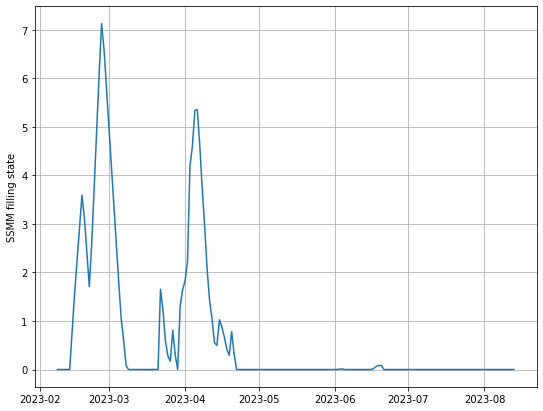

In [133]:
plt.figure(figsize=(9,7))
plt.plot(times,np.cumsum(newc1+newc2)-np.cumsum(tm_used))
plt.ylabel('SSMM filling state')
plt.grid()

In [134]:
(newc1+newc2)[times>datetime.date(2023,3,15)].sum()

34.997348592

In [135]:
PHI.part1.history.keys()
r1 = np.asarray(PHI.part1.history['raw'])[1:]
r2 = np.asarray(PHI.part2.history['raw'])[1:]
f1 = np.asarray(PHI.part1.history['compr'])[1:]
f2 = np.asarray(PHI.part2.history['compr'])[1:]
c1 = np.asarray(PHI.part1.history['crop'])[1:]
c2 = np.asarray(PHI.part2.history['crop'])[1:]
p1 = np.asarray(PHI.part1.history['proc'])[1:]
p2 = np.asarray(PHI.part2.history['proc'])[1:]
k1 = np.asarray(PHI.part1.history['pack'])[1:]
k2 = np.asarray(PHI.part2.history['pack'])[1:]
s1 = np.asarray(PHI.part1.history['start'])[1:]
s2 = np.asarray(PHI.part2.history['start'])[1:]
e1 = np.asarray(PHI.part1.history['end'])[1:]
e2 = np.asarray(PHI.part2.history['end'])[1:]

ind1 = []
for i in range(s1.size):
    if r1[i] < 0:
        ind1 += [-.6]
    elif r1[i] != 0:
        ind1 += [.3]
    elif c1[i] != 0:
        ind1 += [1.3]
    elif k1[i] != 0:
        ind1 += [2.3]
    elif f1[i] != 0:
        ind1 += [3.3]
    elif p1[i] != 0:
        ind1 += [4.3]
    else:
#         print(i)
        ind1 += [0]
ind1 = np.asarray(ind1)    
ind2 = []
for i in range(s2.size):
    if r2[i] < 0:
        ind2 += [-.3]
    elif r2[i] != 0:
        ind2 += [.6]
    elif c2[i] != 0:
        ind2 += [1.6]
    elif k2[i] != 0:
        ind2 += [2.6]
    elif f2[i] != 0:
        ind2 += [3.6]
    elif p2[i] != 0:
        ind2 += [4.6]
    else:
#         print(i)
        ind2 += [0]
ind2 = np.asarray(ind2)    

import matplotlib.dates as mdates


0

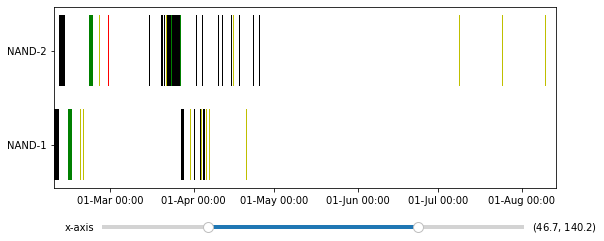

In [136]:
fig = plt.figure(figsize=(9,4))
fig.subplots_adjust(bottom=0.25)
# plt.barh(ind1,e1-s1,.3, left=s1)
# plt.barh(ind2,e2-s2,.3, left=s2)
# plt.gcf().autofmt_xdate()
# plt.xlim(min(s1[:10].min(),s2[:10].min()), max(e1[:10].max(),e2[:10].max()))
plt.barh(1,(e1-s1)[ind1==-.6],.75,left=s1[ind1==-.6],color='r')
plt.barh(1,(e1-s1)[ind1==.3],.75,left=s1[ind1==.3],color='k')
plt.barh(1,(e1-s1)[ind1==1.3],.75,left=s1[ind1==1.3],color='b')
plt.barh(1,(e1-s1)[ind1==2.3],.75,left=s1[ind1==2.3],color='g')
plt.barh(1,(e1-s1)[ind1==3.3],.75,left=s1[ind1==3.3],color='y')
plt.barh(1,(e1-s1)[ind1==4.3],.75,left=s1[ind1==4.3],color='m')

plt.barh(2,(e2-s2)[ind2==-.3],.75,left=s2[ind2==-.3],color='r')
plt.barh(2,(e2-s2)[ind2==.6],.75,left=s2[ind2==.6],color='k')
plt.barh(2,(e2-s2)[ind2==1.6],.75,left=s2[ind2==1.6],color='b')
plt.barh(2,(e2-s2)[ind2==2.6],.75,left=s2[ind2==2.6],color='g')
plt.barh(2,(e2-s2)[ind2==3.6],.75,left=s2[ind2==3.6],color='y')
plt.barh(2,(e2-s2)[ind2==4.6],.75,left=s2[ind2==4.6],color='m')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b %H:%M'))
# plt.yticks([-.6,-.3,.3,.6,1.3,1.6,2.3,2.6,3.3,3.6],['N1-Format','N2-Format','N1-Obs','N2-Obs','N1-Crop','N2-Crop','N1-Pack','N2-Pack','N1-Flush','N2-Flush','N1-Proc','N2-Proc']);
# ax.set_yticks([-.6,-.3,.3,.6,1.3,1.6,2.3,2.6,3.3,3.6],['N1-Format','N2-Format','N1-Obs','N2-Obs','N1-Crop','N2-Crop','N1-Pack','N2-Pack','N1-Flush','N2-Flush']);
ax.set_yticks([1,2],['NAND-1','NAND-2']);

from matplotlib.widgets import RangeSlider # , Button, RadioButtons

# axcolor = 'lightgoldenrodyellow'
slider_ax = fig.add_axes([0.2, 0.1, 0.65, 0.03])

min0 = min(s1.min(),s2.min())
max0 = max(e1.max(),e2.max())

slider = RangeSlider(slider_ax, "x-axis", (min0-min0).total_seconds()/60/60/24, (max0-min0).total_seconds()/60/60/24)

def update(val):    
    ax.set_xlim([min0+TD(days=val[0]),min0+TD(days=val[1])])

slider.on_changed(update)
# plt.show()


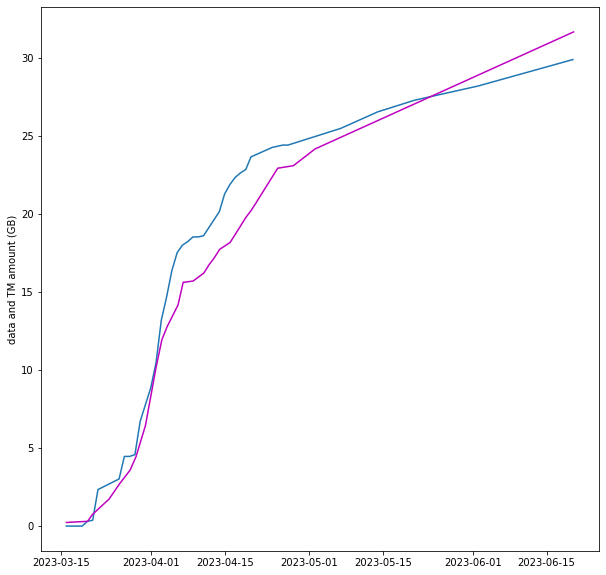

In [137]:
cond = np.logical_and(times>=FL['date'][0].date(), times<=FL['date'][-1].date())
plt.figure(figsize=(10,10))
plt.ylabel('data and TM amount (GB)')
plt.plot(times[cond],np.cumsum(newc1[cond]+newc2[cond]),label='cumulative compressed data')
# plt.plot(times[cond],np.cumsum(tm_used[cond]),label='cumulative TM usage')
# plt.plot(times[cond],np.cumsum(newc1[cond]+newc2[cond])-np.cumsum(tm_used[cond]),label='SSMM filling state')
plt.plot(FL['date'],-np.cumsum(FL['flush']*2**20/1e9),'m',label='SOOPK FLUSH')
# plt.xlim(DT(2023,3,15),DT(2023,4,10)); plt.ylim(0,20)
